# Real data validation
- Note that both measurement and library data peaks were considered only if surpassed 1% of maximal spectral intensity

In [1]:
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [2]:


# # if the predictions were generated in this galaxy session set to True
# is_fresh = False
# suffix = "" if is_fresh else ".txt"


predictors = ["mlp_2_.3", "mlp_2_.1", "GPT2_5"]
predictor= predictors[0]

%load_ext autoreload
%autoreload 2

import sys; sys.path.append("..")

In [4]:
from pipeline_utils import get_galaxy_filename

measured_path = [get_galaxy_filename('RI using kovats of Mass spectra from RAMClustR', '../data', ["enh", "pred"])]
matched_path = [get_galaxy_filename('matchms output formatter _get-thresholded-data_', '../data')]
reference_lib = "../data/1_rcx_gc-orbitrap_metabolites_20210817.msp.msp"
concs = ["all"]

In [5]:
measured_path

[None]

In [7]:
from matchms.importing import load_from_msp
from utils.data_utils import spectrum_processing, get_n_samples
from utils.helpers import get_mz_vector, get_his_size, compact_to_mz
from utils.visual_utils import plot_spectrum_sample_prediction

import numpy as np
from matchms.filtering import normalize_intensities

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matchms.plotting import spectrum_plots

from collections import defaultdict
from matchms.plotting import plot_spectrum, plot_spectra_mirror
from matchms import Spectrum
from matchms.filtering import select_by_relative_intensity
import matplotlib


## Data loading

In [8]:
def get_spectra(path, normalize=True):
    # Load data from MSP file and apply filters
    spectrums = [*load_from_msp(path,  metadata_harmonization=False)]
    # Omit spectrums that didn't qualify for analysis
    if normalize:
        spectrums = [normalize_intensities(s) for s in spectrums if s is not None]
    
    spectrums =  [select_by_relative_intensity(s, intensity_from=0.01) for s in spectrums]
    return spectrums

In [9]:
measured, matched = dict(), dict()
for i, conc in enumerate(concs):
    measured[conc] = {s.metadata["compound_name"]:s for s in get_spectra(f"{measured_path[i]}")}
    measured[conc+"_enh"] = {s.metadata["compound_name"]:s for s in get_spectra(get_galaxy_filename(f"{measured_path[i].split('/')[-1][:-4]}_enh_{predictor}.msp", "../data"))}
    measured[conc+"_pred"] = {s.metadata["compound_name"]:s for s in get_spectra(get_galaxy_filename(f"{measured_path[i].split('/')[-1][:-4]}_pred_{predictor}.msp", "../data"),
                                                                                normalize=False)}

    matched[conc] = pd.read_csv(f"{matched_path[i]}", sep="\t", names=["id", "name", "n_ions", 	"confidence"]).iloc[1:]
#     matched[conc+"_enh"] = pd.read_csv(f"{matched_path[i]}", sep="\t", names=["id", "name", "n_ions", 	"confidence"]).iloc[1:]
    

FileNotFoundError: [Errno 2] No such file or directory: 'None'

In [7]:
library = {s.metadata["compound_name"]:s for s in get_spectra(reference_lib)}

## Pair measured spectra with database spectra

In [8]:
def couple(meas_id, measured, library, matched, conc="0", repetition_count=0, mes_suffix=""):
    mask = matched[conc]["id"] == meas_id
    if not (mask).any():
        return measured[conc+mes_suffix][meas_id], None
    compound_name = matched[conc]["name"][mask].values[repetition_count]
    return measured[conc+mes_suffix][meas_id], library[compound_name]

In [9]:
def couple_plot(meas_id, measured, library, matched, conc="0", repetition_count=0):
    spec, lib = couple(meas_id, measured, library, matched, conc=conc, repetition_count=repetition_count)
    
    if lib is not None:
        false_detected = set(spec.peaks.mz.astype(int)).difference(set(lib.peaks.mz.astype(int)))
        missing_mz = set(lib.peaks.mz.astype(int)).difference(set(lib.peaks.mz.astype(int)).intersection(set(spec.peaks.mz.astype(int))))
        print(f"Spectrum {meas_id} - detected peaks: {len(spec.peaks.mz)}")
        print(f"When matched to {lib.metadata['compound_name']}: {matched[conc][matched[conc].id==meas_id].n_ions.values[repetition_count]} matched ions with {matched[conc][matched[conc].id==meas_id].confidence.values[repetition_count]} total confidence")
        print(f"In this match, {len(false_detected)} peaks were not in library spectrum and {len(missing_mz)} peaks from library spectrum were missing")
#         plot_spectrum_sample_prediction(lib, missing_mz, [], false_detected, [])
        print()
    return spec, lib


## Evaluate if has a counterpart in reference or not

In [10]:
def evaluate(pred, lib, tol=0.5):
    corr, wrong = list(), list()
    for mz in pred.peaks.mz:
        if (abs(lib.peaks.mz - mz) < tol).any():
            corr.append(mz)
        else:
            wrong.append(mz)
    return np.array(corr), np.array(wrong)

## Evaluate prediction 

In [11]:
def get_order(matched, conc=conc):
    repetition_counter = defaultdict(lambda: 0)
    order_dict = dict()
    for meas_id in matched[conc].id:
        order_dict[(meas_id, repetition_counter[meas_id])] = int(matched[conc].n_ions[matched[conc].id == meas_id].values[repetition_counter[meas_id]])    
        repetition_counter[meas_id] += 1
    return order_dict

In [12]:
to_df=  list()
conc = "all"
ordered = get_order(matched, conc)
for c in reversed(sorted(ordered, key=lambda x: ordered[x])):
    spec_meas, lib_meas = couple(c[0], measured, library, matched, conc=conc, repetition_count=c[1], mes_suffix="")
    corr_meas, wrong_meas = evaluate(spec_meas, lib_meas, tol=0.003)
    missing_peaks = len(lib_meas.peaks) - len(corr_meas)
    additional_peaks = len(wrong_meas)
    
    # switch on to replace the hi-res estimation with low-res (leads to minimal significant changes)
#     missing_peaks = len(np.unique(np.around(lib_meas.peaks.mz))) - len(np.unique(np.around(corr_meas)))
#     additional_peaks = len(np.unique(np.around(wrong_meas)))
    if c[0] in measured[conc+"_pred"]:
        spec, _ = couple(c[0], measured, library, matched, conc=conc, repetition_count=c[1], mes_suffix="_pred")
        corr, wrong = evaluate(spec, lib_meas)
        to_df.append([c[0], lib_meas.get("compound_name"), len(measured[conc][c[0]].peaks), len(lib_meas.peaks), missing_peaks, additional_peaks,len(spec.peaks), len(corr)])
    else:
        to_df.append([c[0], lib_meas.get("compound_name"), len(measured[conc][c[0]].peaks), len(lib_meas.peaks),missing_peaks, additional_peaks, 0, 0])
df = pd.DataFrame(to_df, columns=["meas_id", "c_name", "meas_peaks", "c_peaks", "missing_peaks", "additional_peaks", "pred_peaks", "corr_peaks"])
df

,meas_id,c_name,meas_peaks,c_peaks,missing_peaks,additional_peaks,pred_peaks,corr_peaks
0,C02,Lysine_4TMS,26,51,31,6,3,1
1,C06,Fructose_5TMS isomer 2,17,42,25,0,1,1
2,C06,Fructose_5TMS isomer 1,17,42,28,3,1,1
3,C10,Myo-inositol_6TMS,13,54,43,2,2,2
4,C08,Citric acid_4TMS,9,45,37,1,1,1
5,C16,Uridine_4TMS isomer 1,14,89,77,2,4,3
6,C06,Xylose_4TMS,17,42,32,7,1,1
7,C06,Ribose_4TMS,17,37,26,6,1,1
8,C06,Arabitol_5TMS,17,44,36,9,1,1
9,C06,Arabitol_5TMS,17,44,36,9,1,1


In [13]:
# what is the HALABALA estimated probability of missing a peak? 
(df.missing_peaks/df.c_peaks).mean()

0.8033548101739362

In [14]:
# what is the HALABALA estimated probability of adding a peak?
(df.additional_peaks/df.c_peaks).mean()

0.17353114899550345

In [15]:
# for how % of compounds were some peaks predicted?
sum(df.pred_peaks!=0)/len(df) *100

87.5

In [16]:
# how many peaks were predicted on average?
df.pred_peaks.mean()

1.2083333333333333

In [17]:
# how much of missing peaks were recovered on average (recall)?
(df.corr_peaks/df.missing_peaks ).mean()

0.020074267267694408

In [18]:
# what is the mean precision of the prediction?
np.nanmean(df.corr_peaks/df.pred_peaks)

0.7182539682539681

## Visual inspection - take the compounds sorted by n matched peaks, fill predicted and observe

Spectrum C02 - detected peaks: 26
When matched to Lysine_4TMS: 23 matched ions with 0.92281020332912 total confidence
In this match, 4 peaks were not in library spectrum and 30 peaks from library spectrum were missing



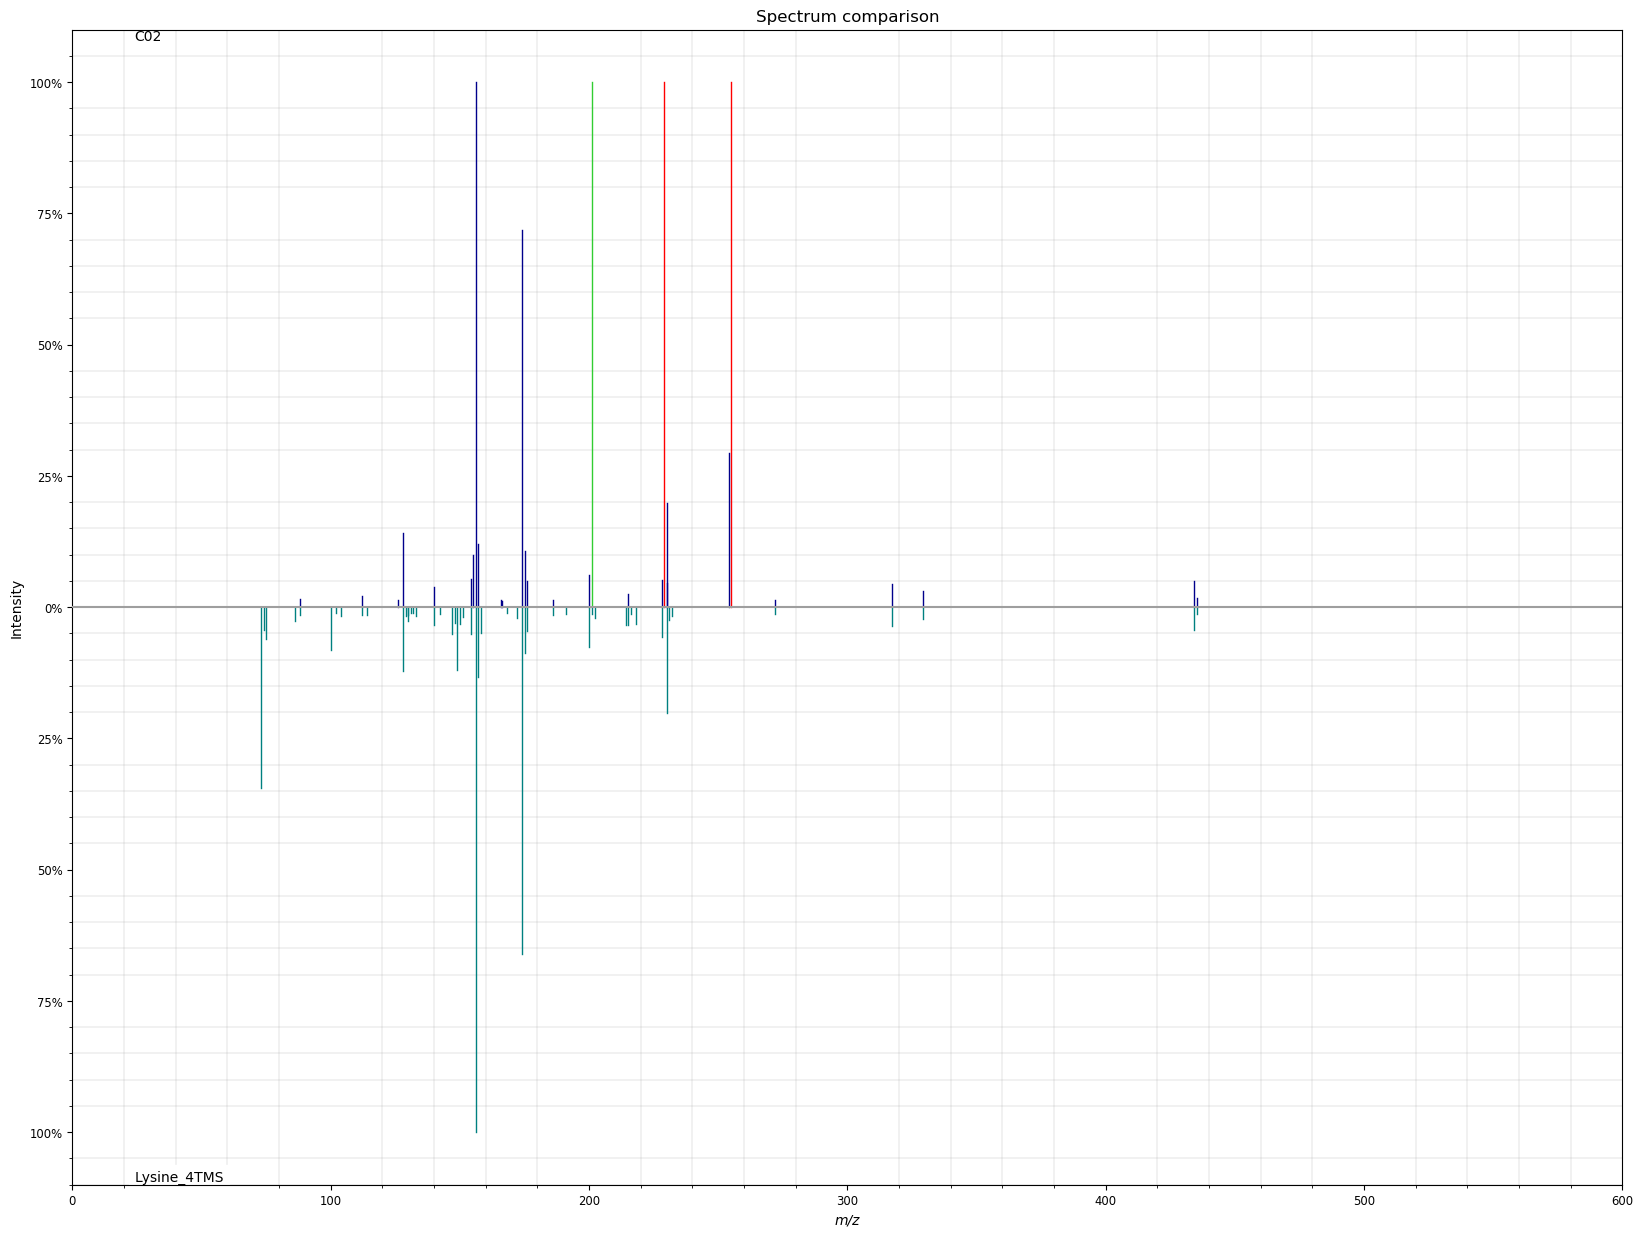

Spectrum C06 - detected peaks: 17
When matched to Fructose_5TMS isomer 2: 18 matched ions with 0.8766808769415186 total confidence
In this match, 0 peaks were not in library spectrum and 25 peaks from library spectrum were missing



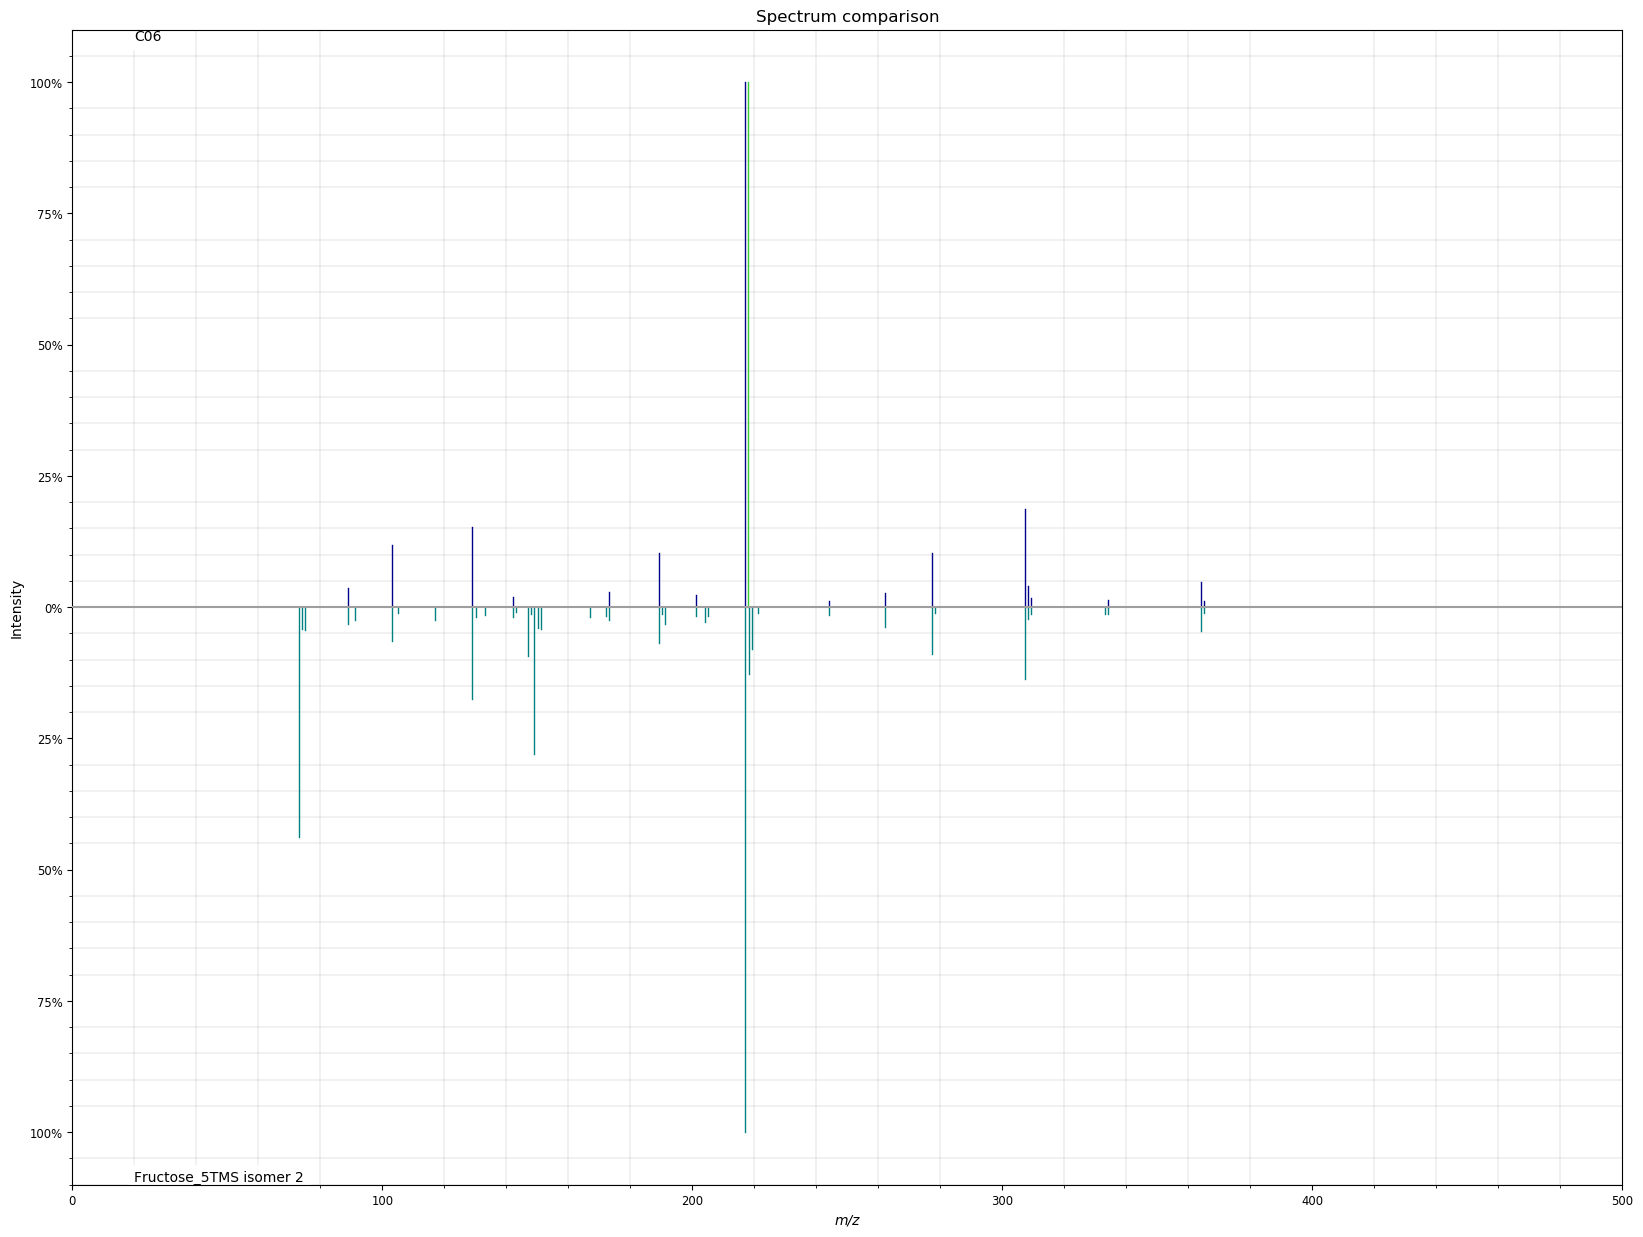

Spectrum C06 - detected peaks: 17
When matched to Fructose_5TMS isomer 1: 15 matched ions with 0.8584115640959713 total confidence
In this match, 3 peaks were not in library spectrum and 27 peaks from library spectrum were missing



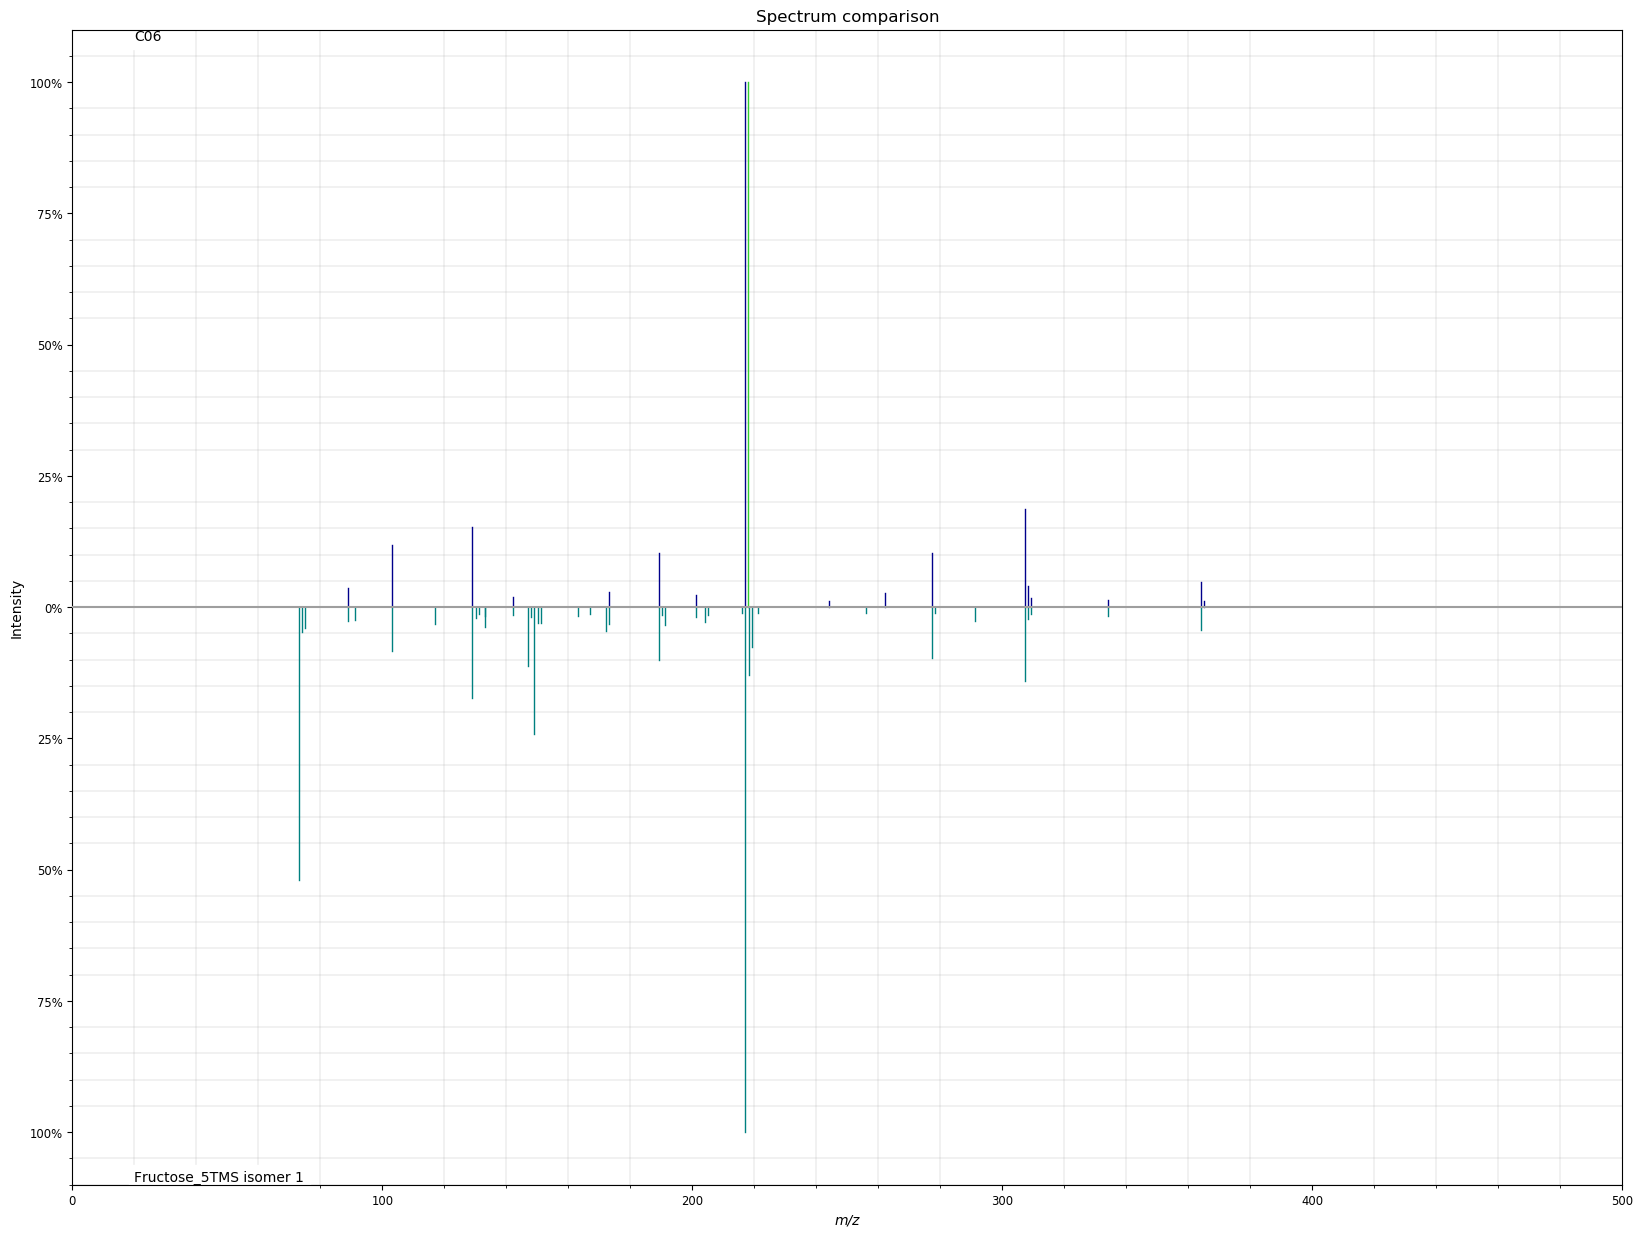

Spectrum C10 - detected peaks: 13
When matched to Myo-inositol_6TMS: 13 matched ions with 0.9155674896314296 total confidence
In this match, 1 peaks were not in library spectrum and 43 peaks from library spectrum were missing



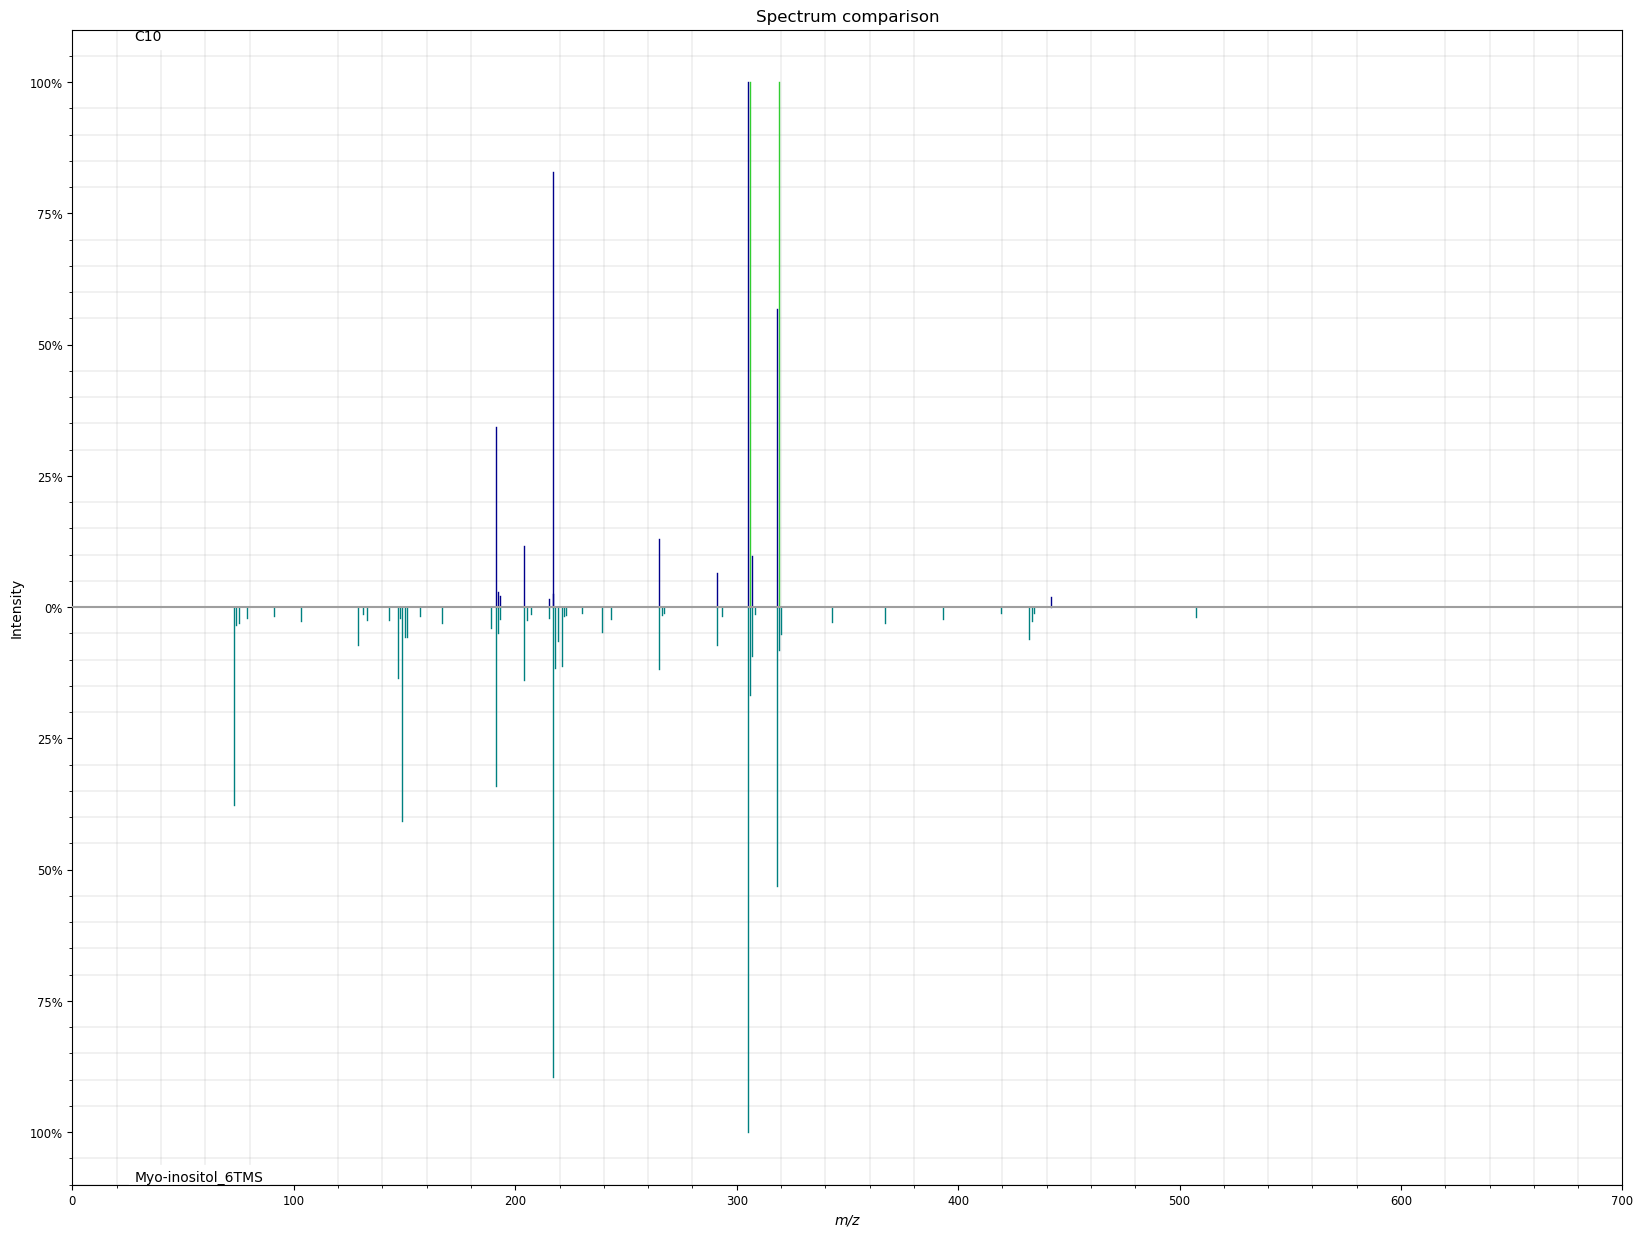

Spectrum C08 - detected peaks: 9
When matched to Citric acid_4TMS: 13 matched ions with 0.8749224326835099 total confidence
In this match, 1 peaks were not in library spectrum and 37 peaks from library spectrum were missing



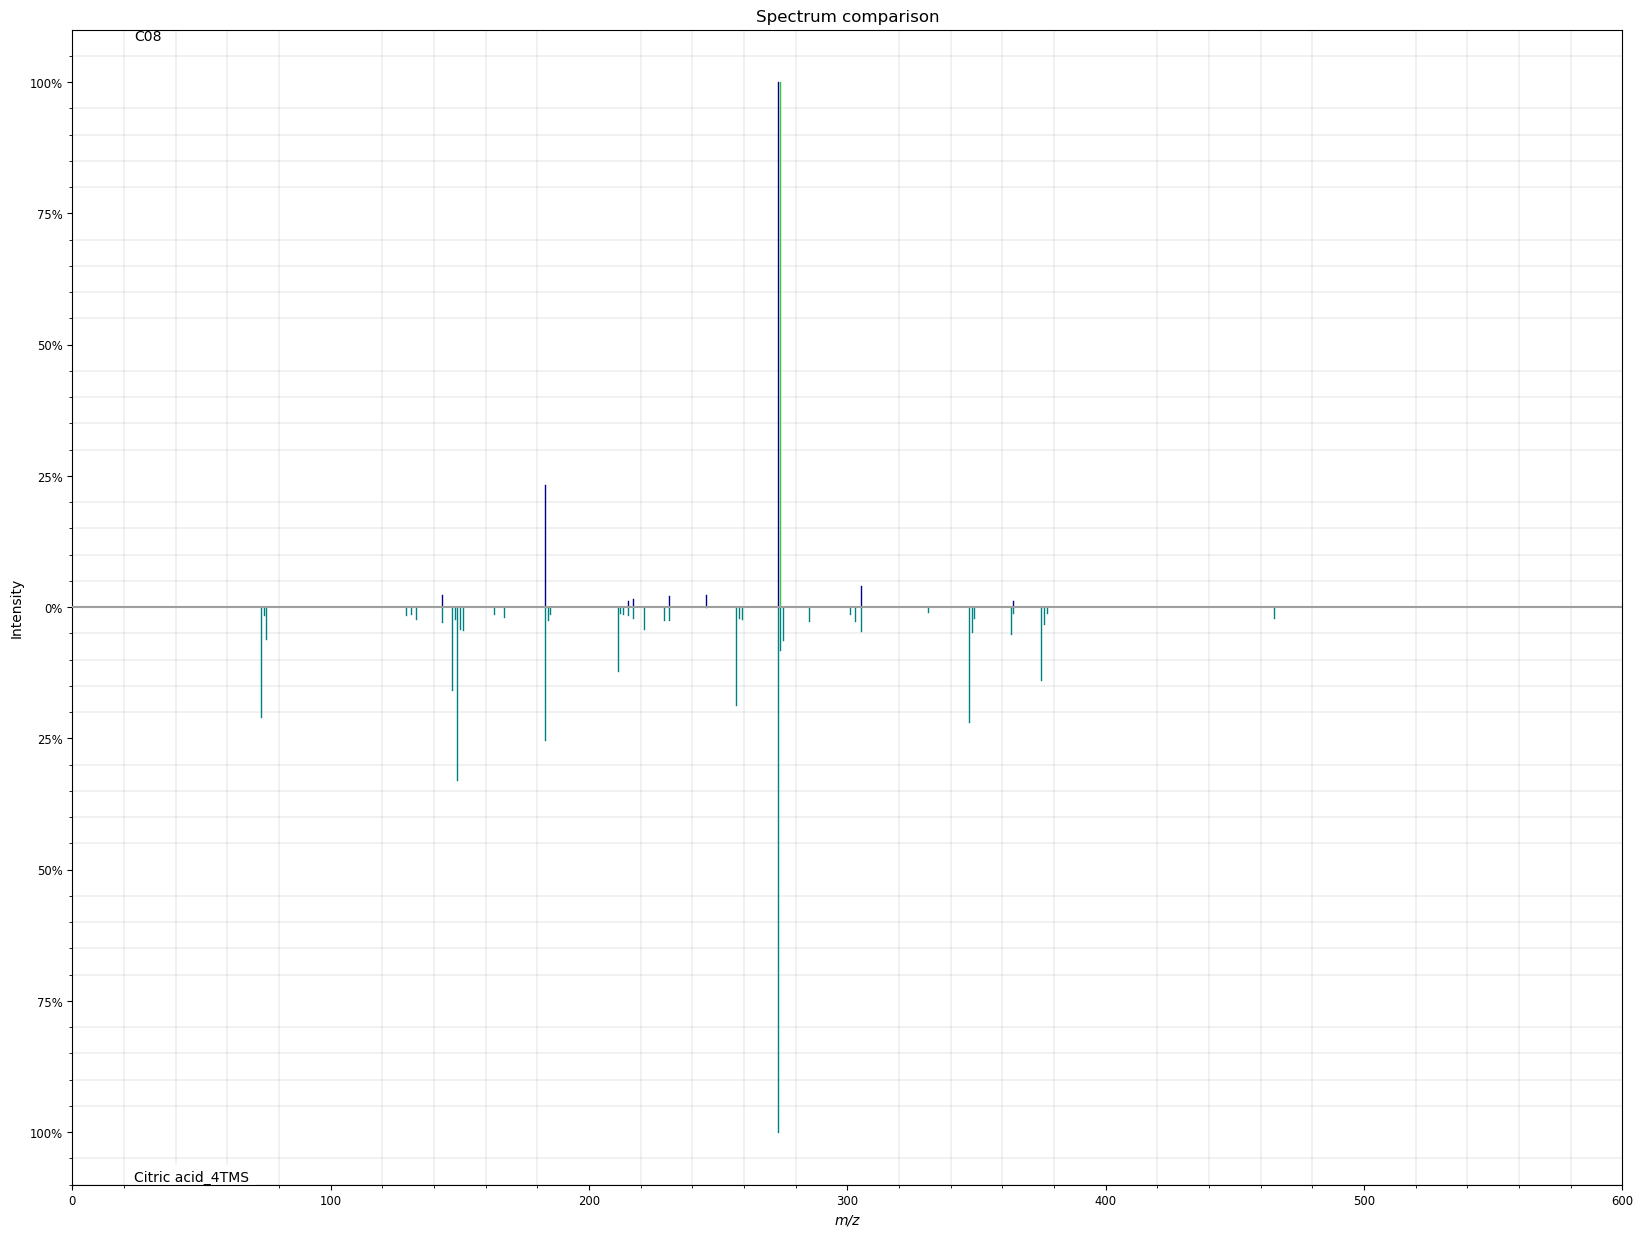

Spectrum C16 - detected peaks: 14
When matched to Uridine_4TMS isomer 1: 12 matched ions with 0.6025062983867928 total confidence
In this match, 0 peaks were not in library spectrum and 75 peaks from library spectrum were missing



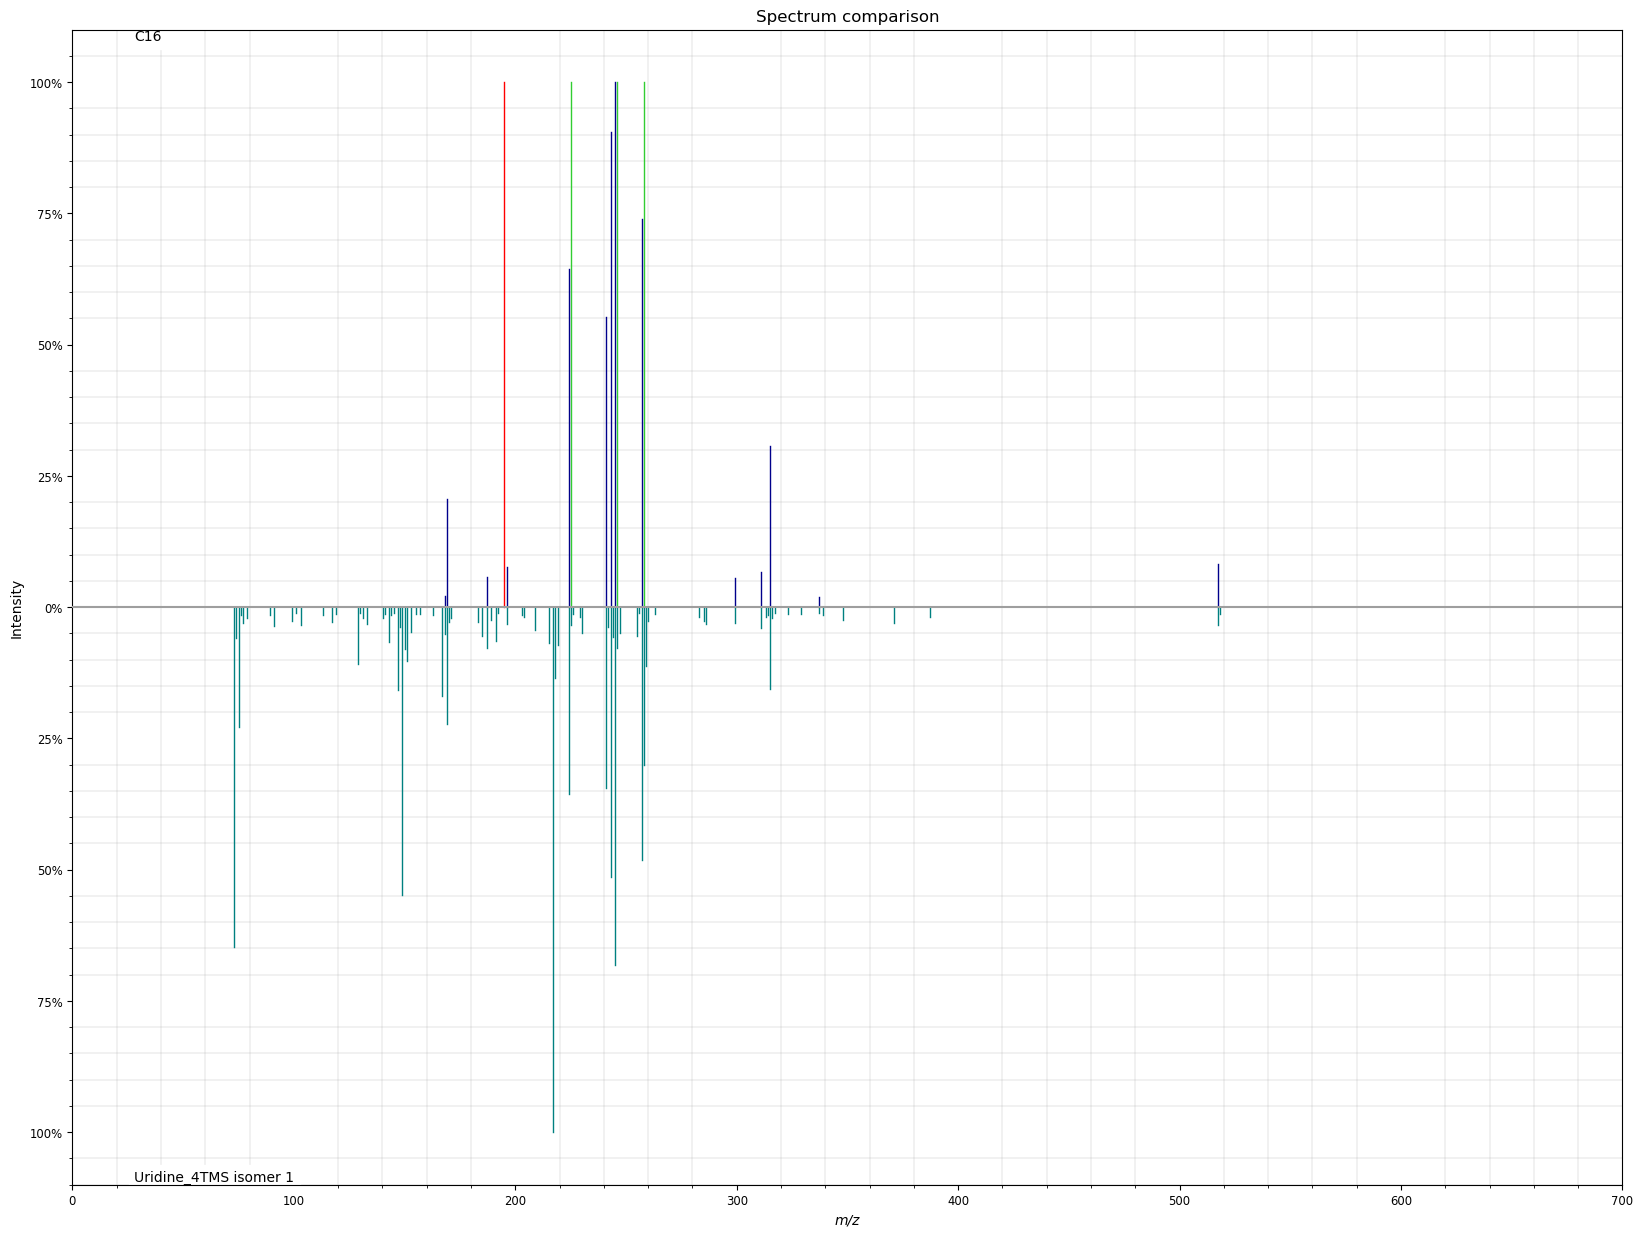

Spectrum C06 - detected peaks: 17
When matched to Xylose_4TMS: 11 matched ions with 0.8140434072629077 total confidence
In this match, 7 peaks were not in library spectrum and 31 peaks from library spectrum were missing



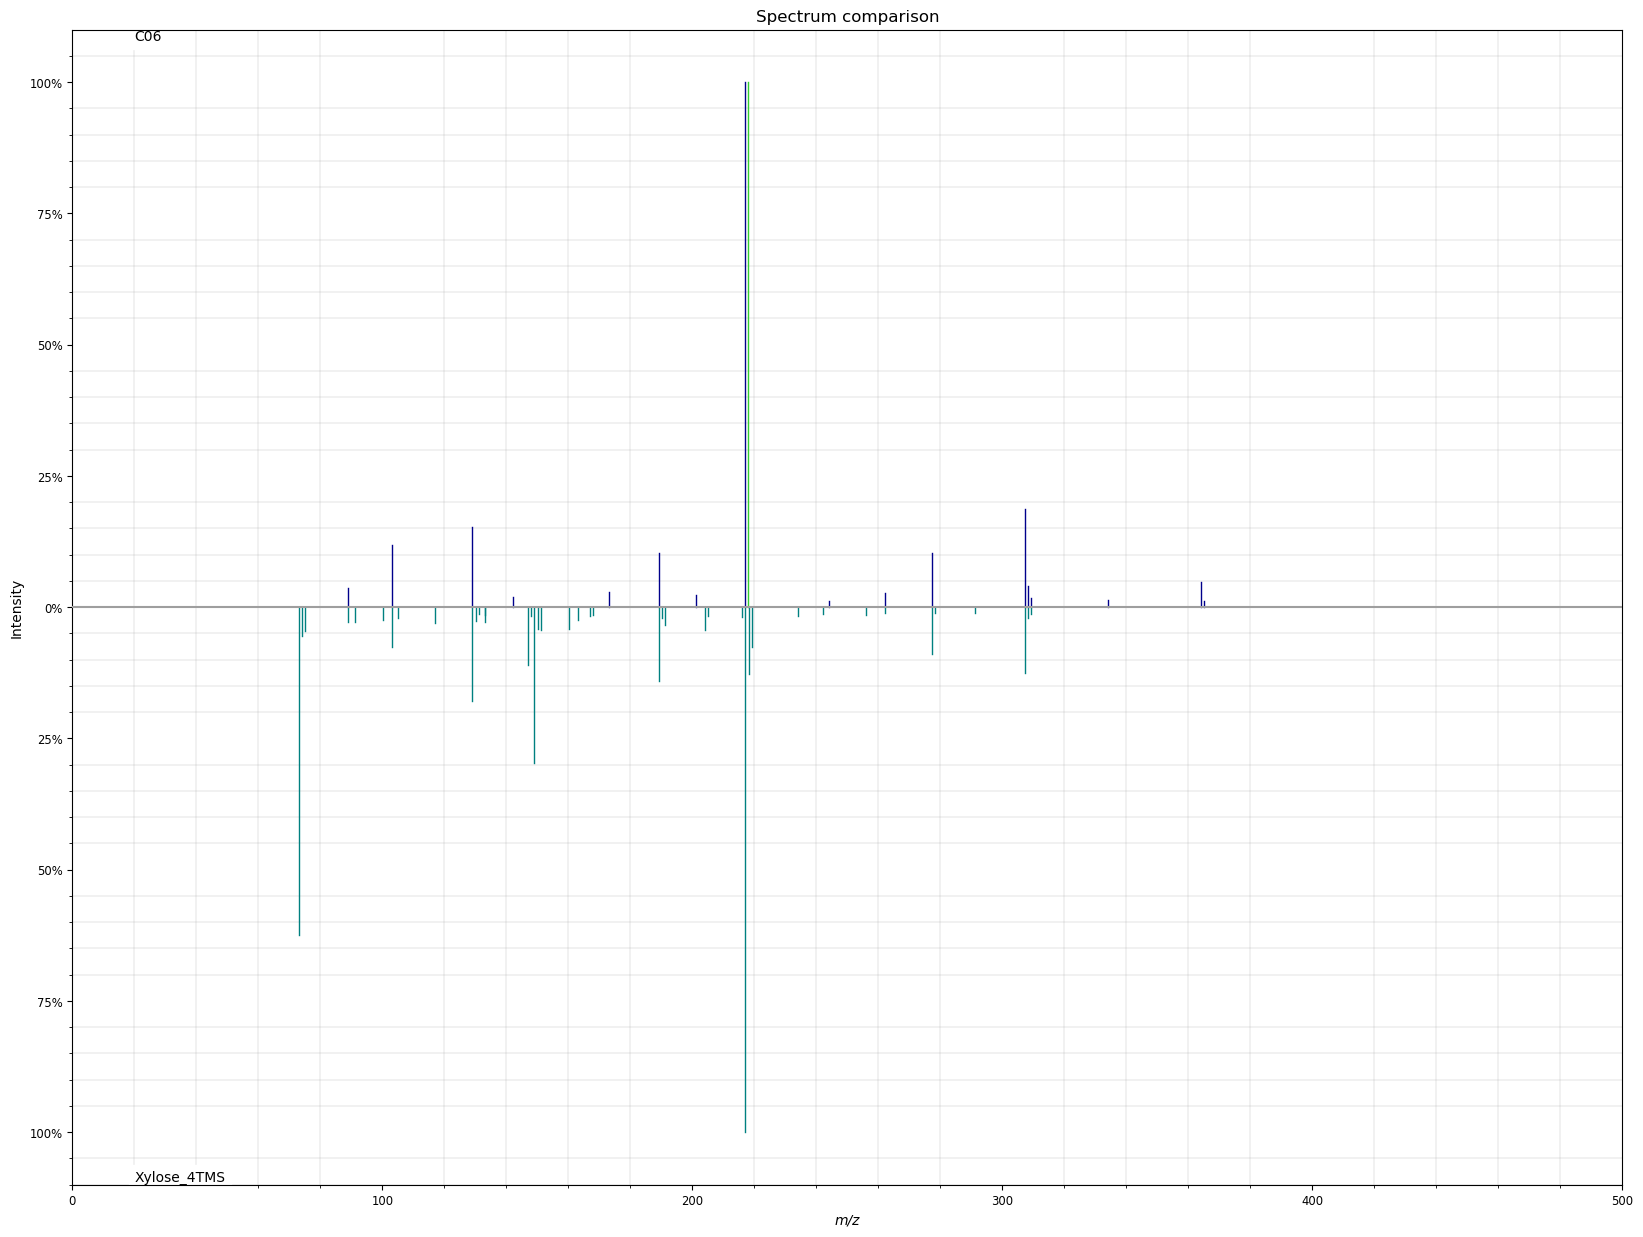

Spectrum C06 - detected peaks: 17
When matched to Ribose_4TMS: 11 matched ions with 0.8566412457759247 total confidence
In this match, 6 peaks were not in library spectrum and 26 peaks from library spectrum were missing



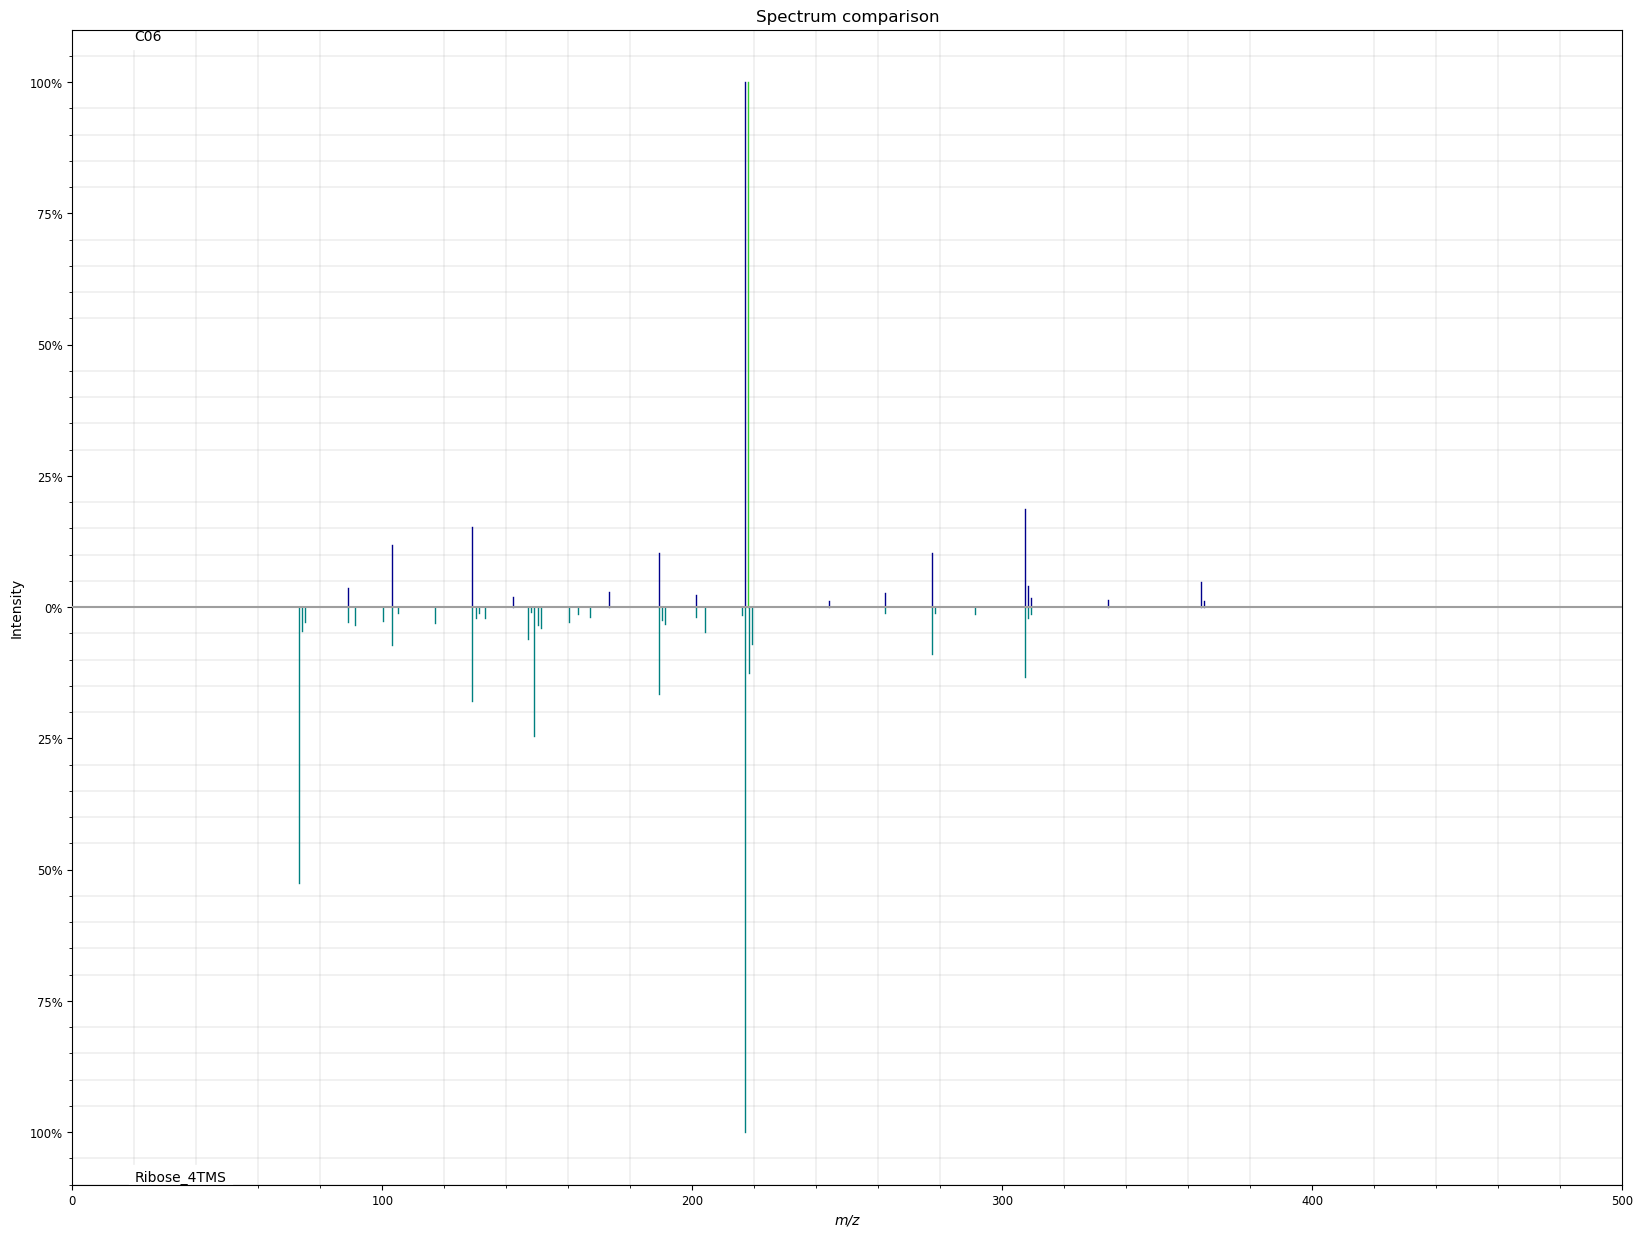

Spectrum C06 - detected peaks: 17
When matched to Arabitol_5TMS: 10 matched ions with 0.7972294938455029 total confidence
In this match, 9 peaks were not in library spectrum and 35 peaks from library spectrum were missing



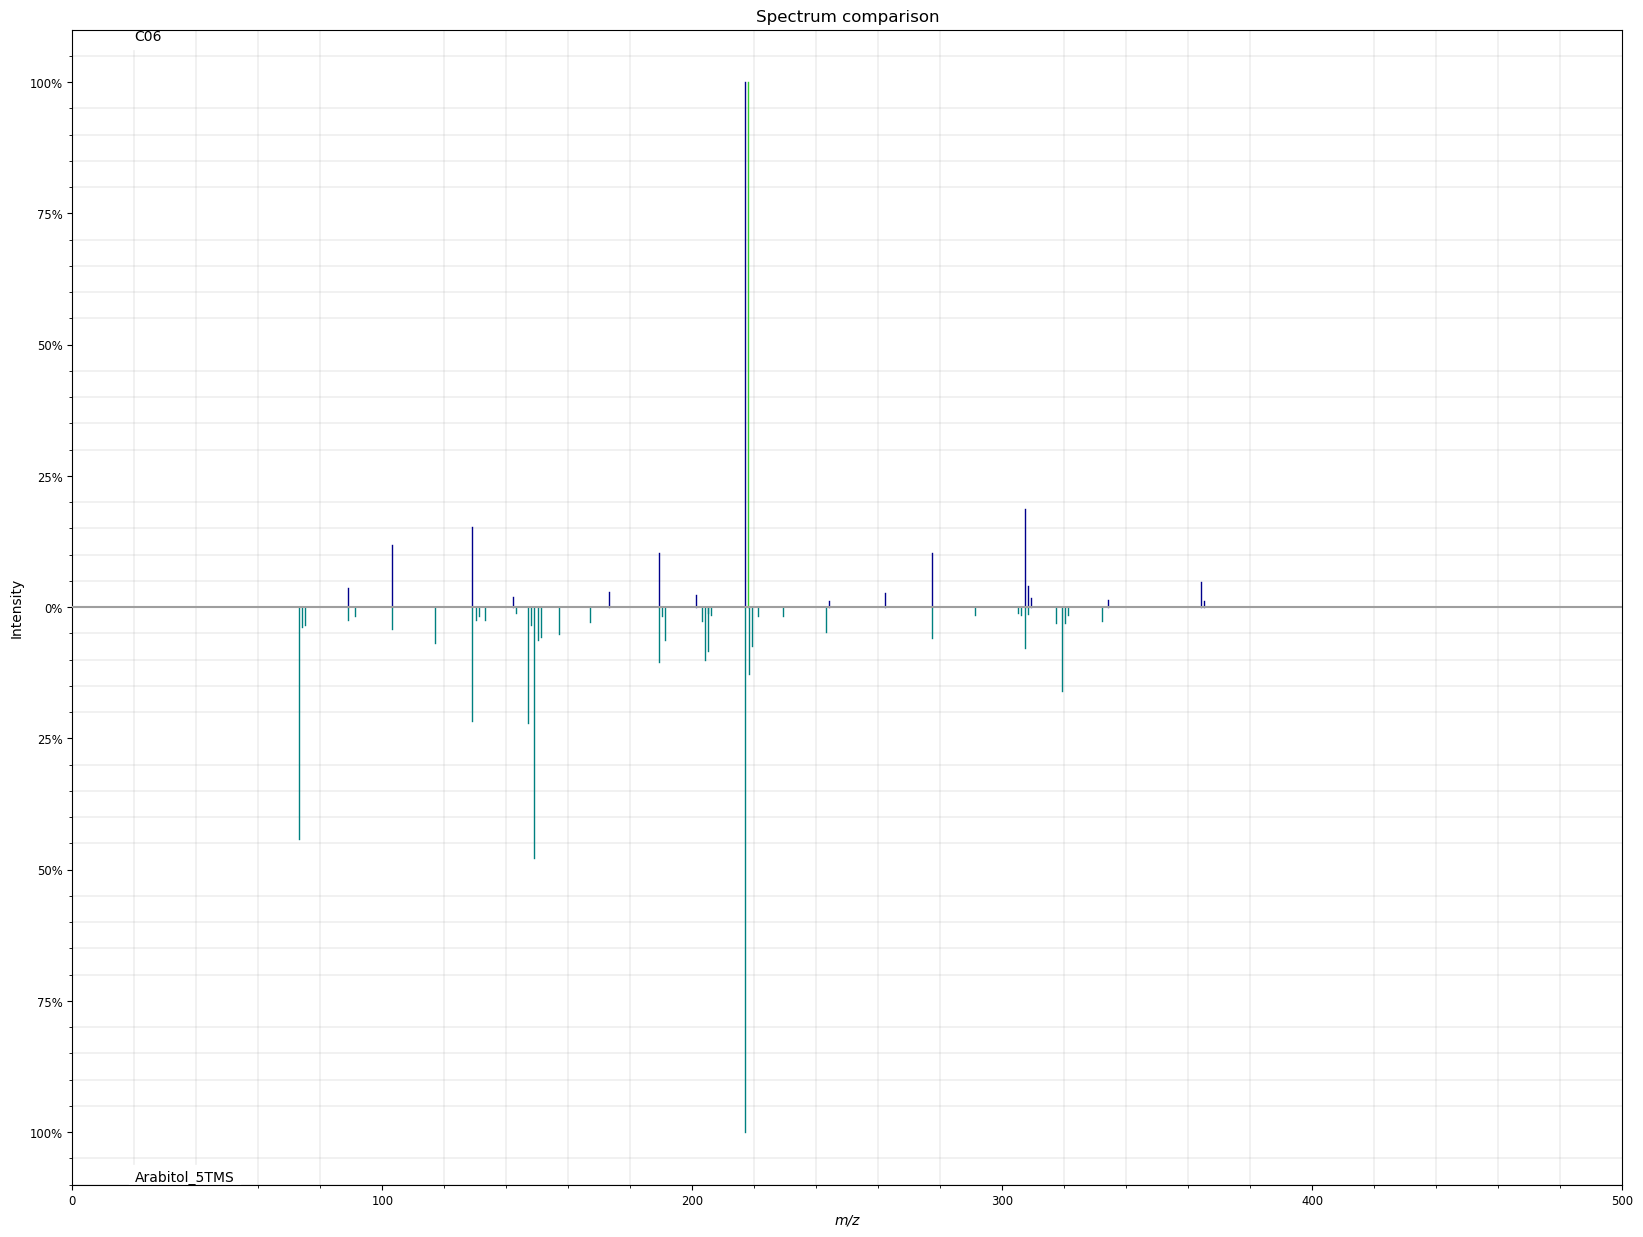

Spectrum C06 - detected peaks: 17
When matched to Arabitol_5TMS: 10 matched ions with 0.796552247937575 total confidence
In this match, 9 peaks were not in library spectrum and 35 peaks from library spectrum were missing



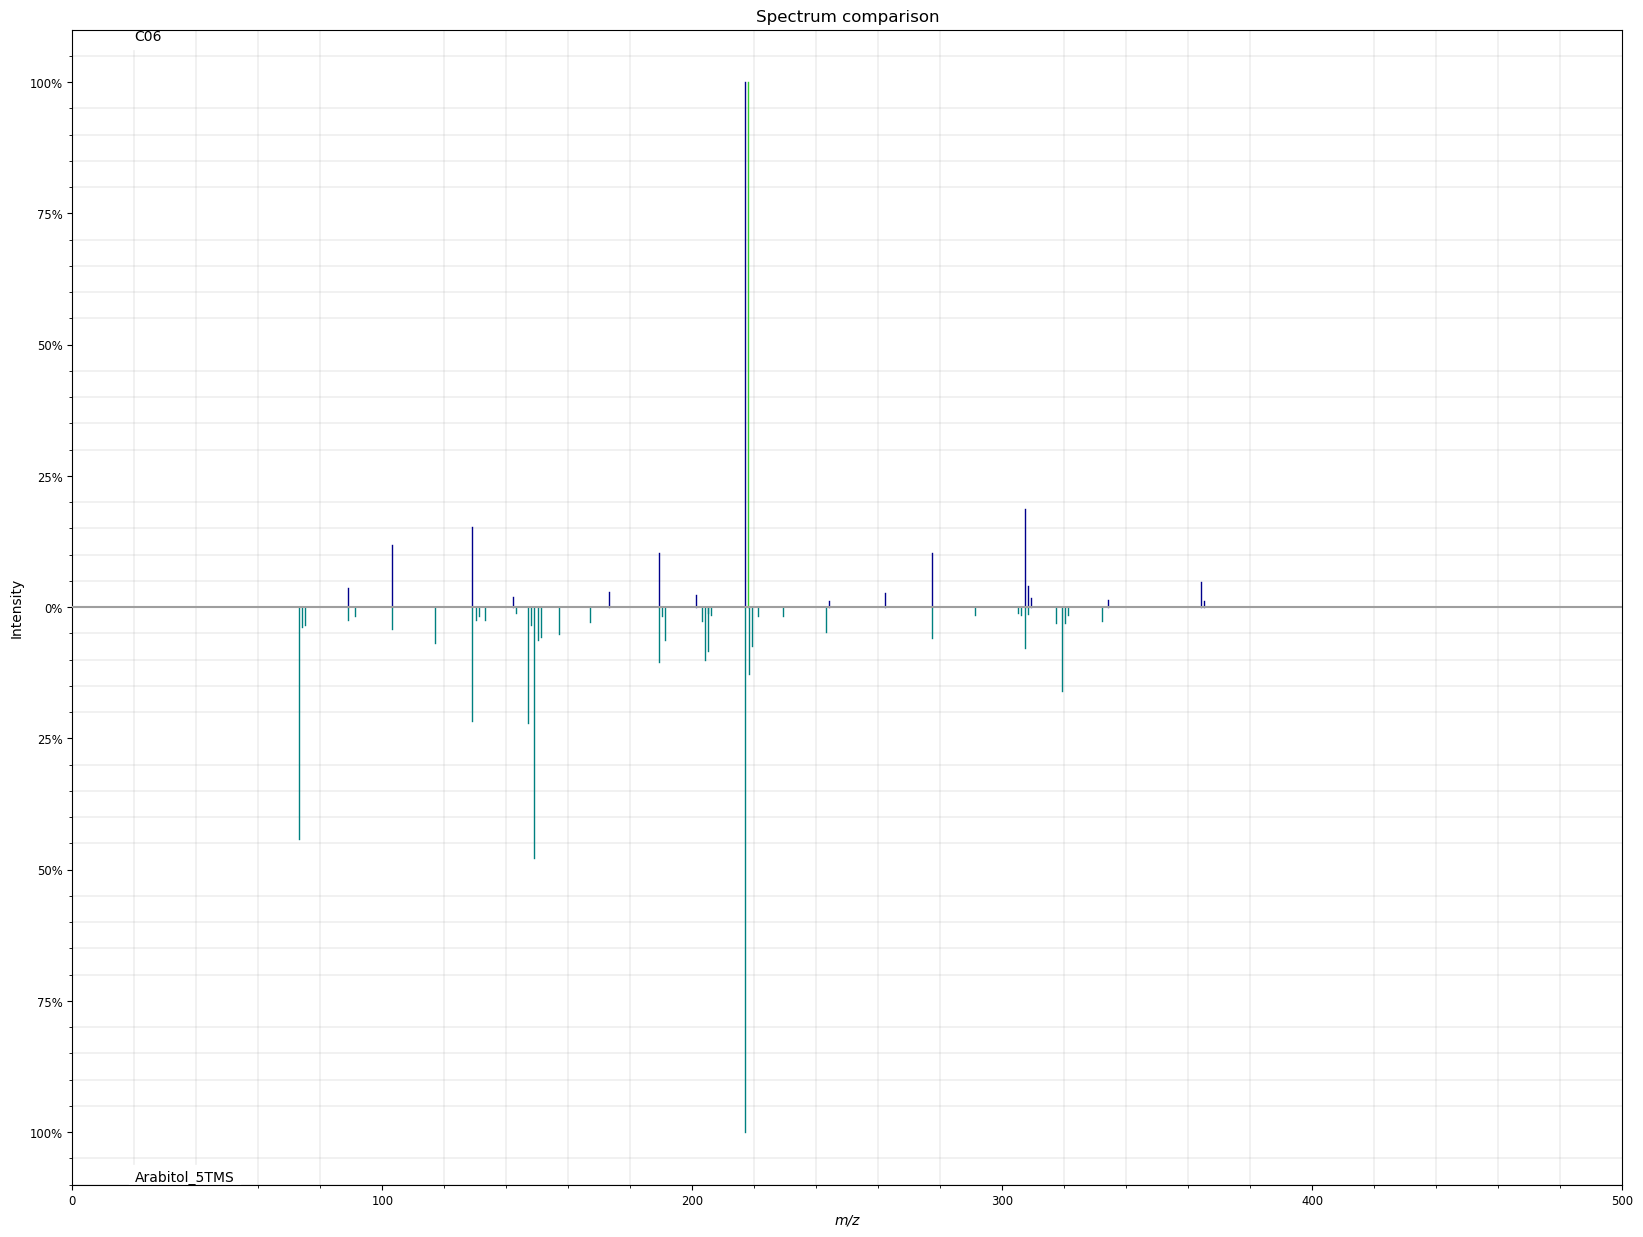

Spectrum C06 - detected peaks: 17
When matched to Arabitol_5TMS: 9 matched ions with 0.7972294938455029 total confidence
In this match, 9 peaks were not in library spectrum and 35 peaks from library spectrum were missing



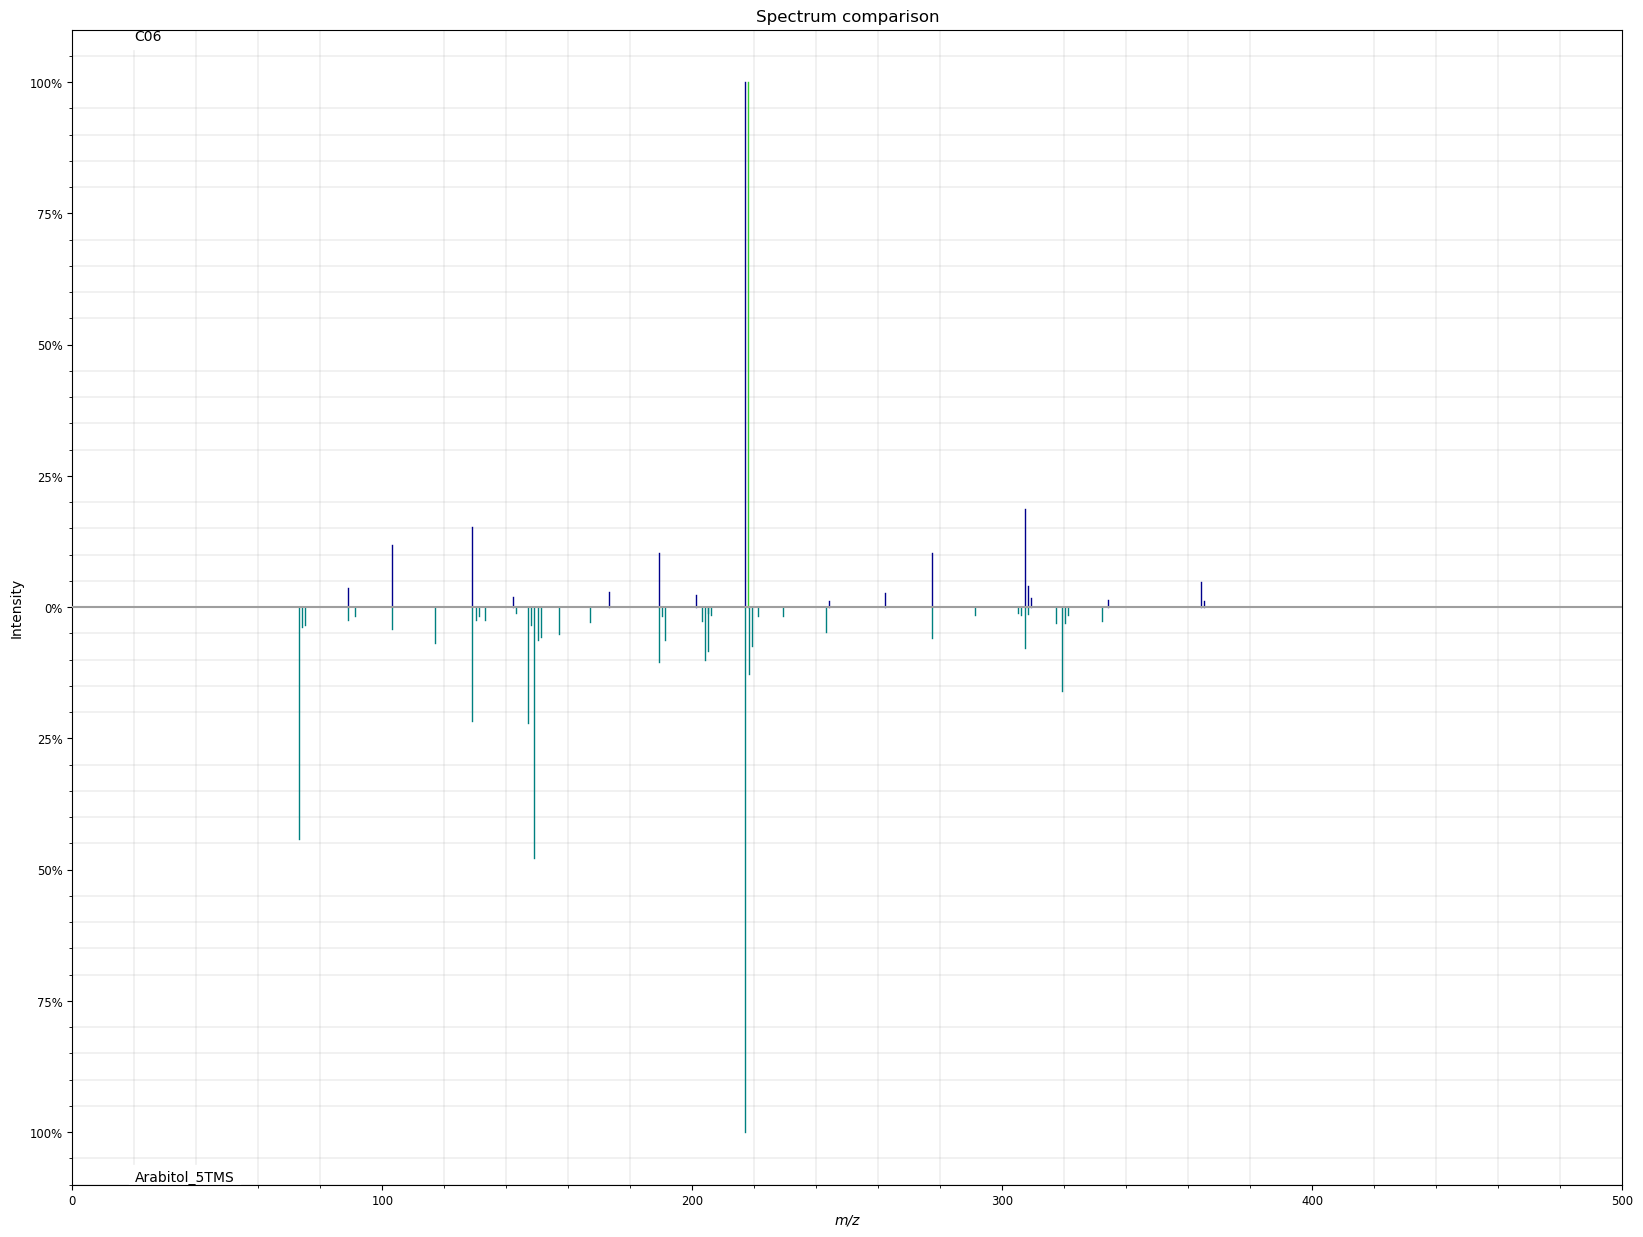

Spectrum C06 - detected peaks: 17
When matched to Arabitol_5TMS: 9 matched ions with 0.796552247937575 total confidence
In this match, 9 peaks were not in library spectrum and 35 peaks from library spectrum were missing



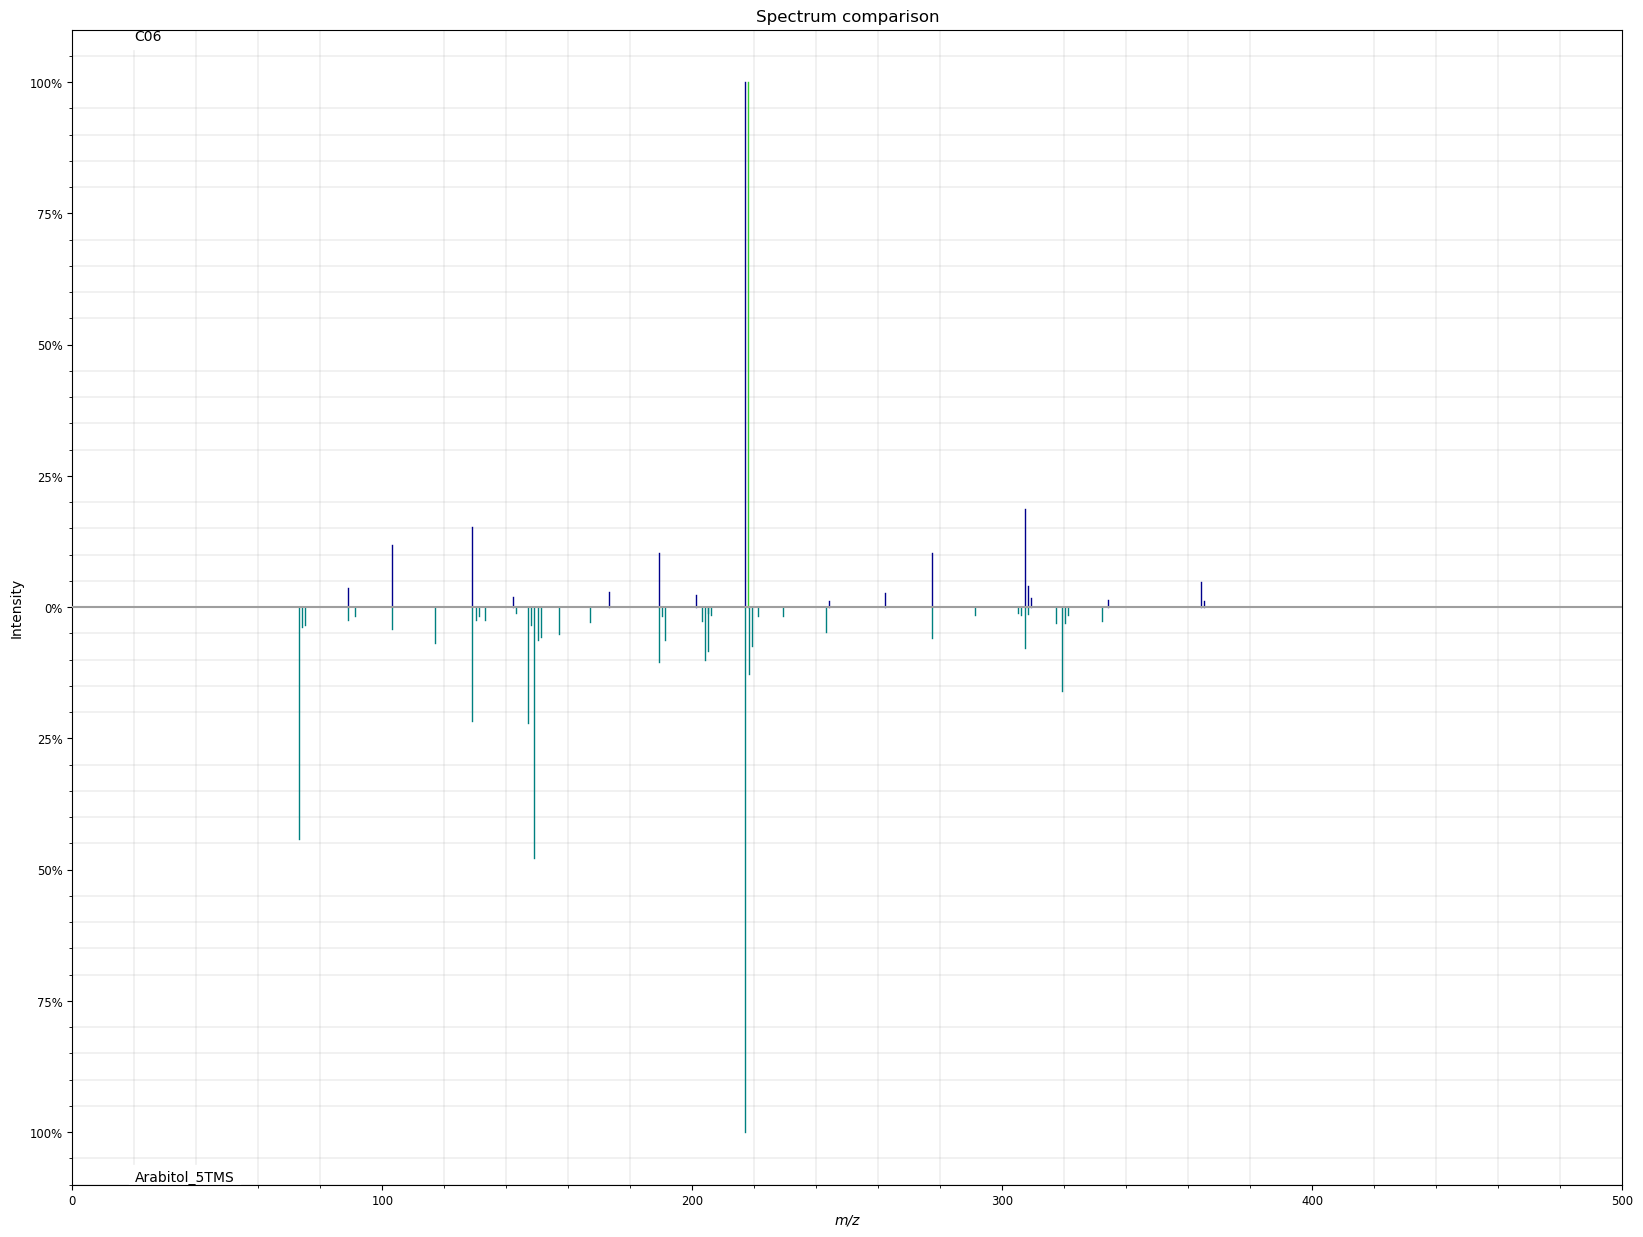

Spectrum C26 - detected peaks: 10
When matched to Threonine_3TMS spectra 1: 8 matched ions with 0.7965404736026365 total confidence
In this match, 0 peaks were not in library spectrum and 75 peaks from library spectrum were missing



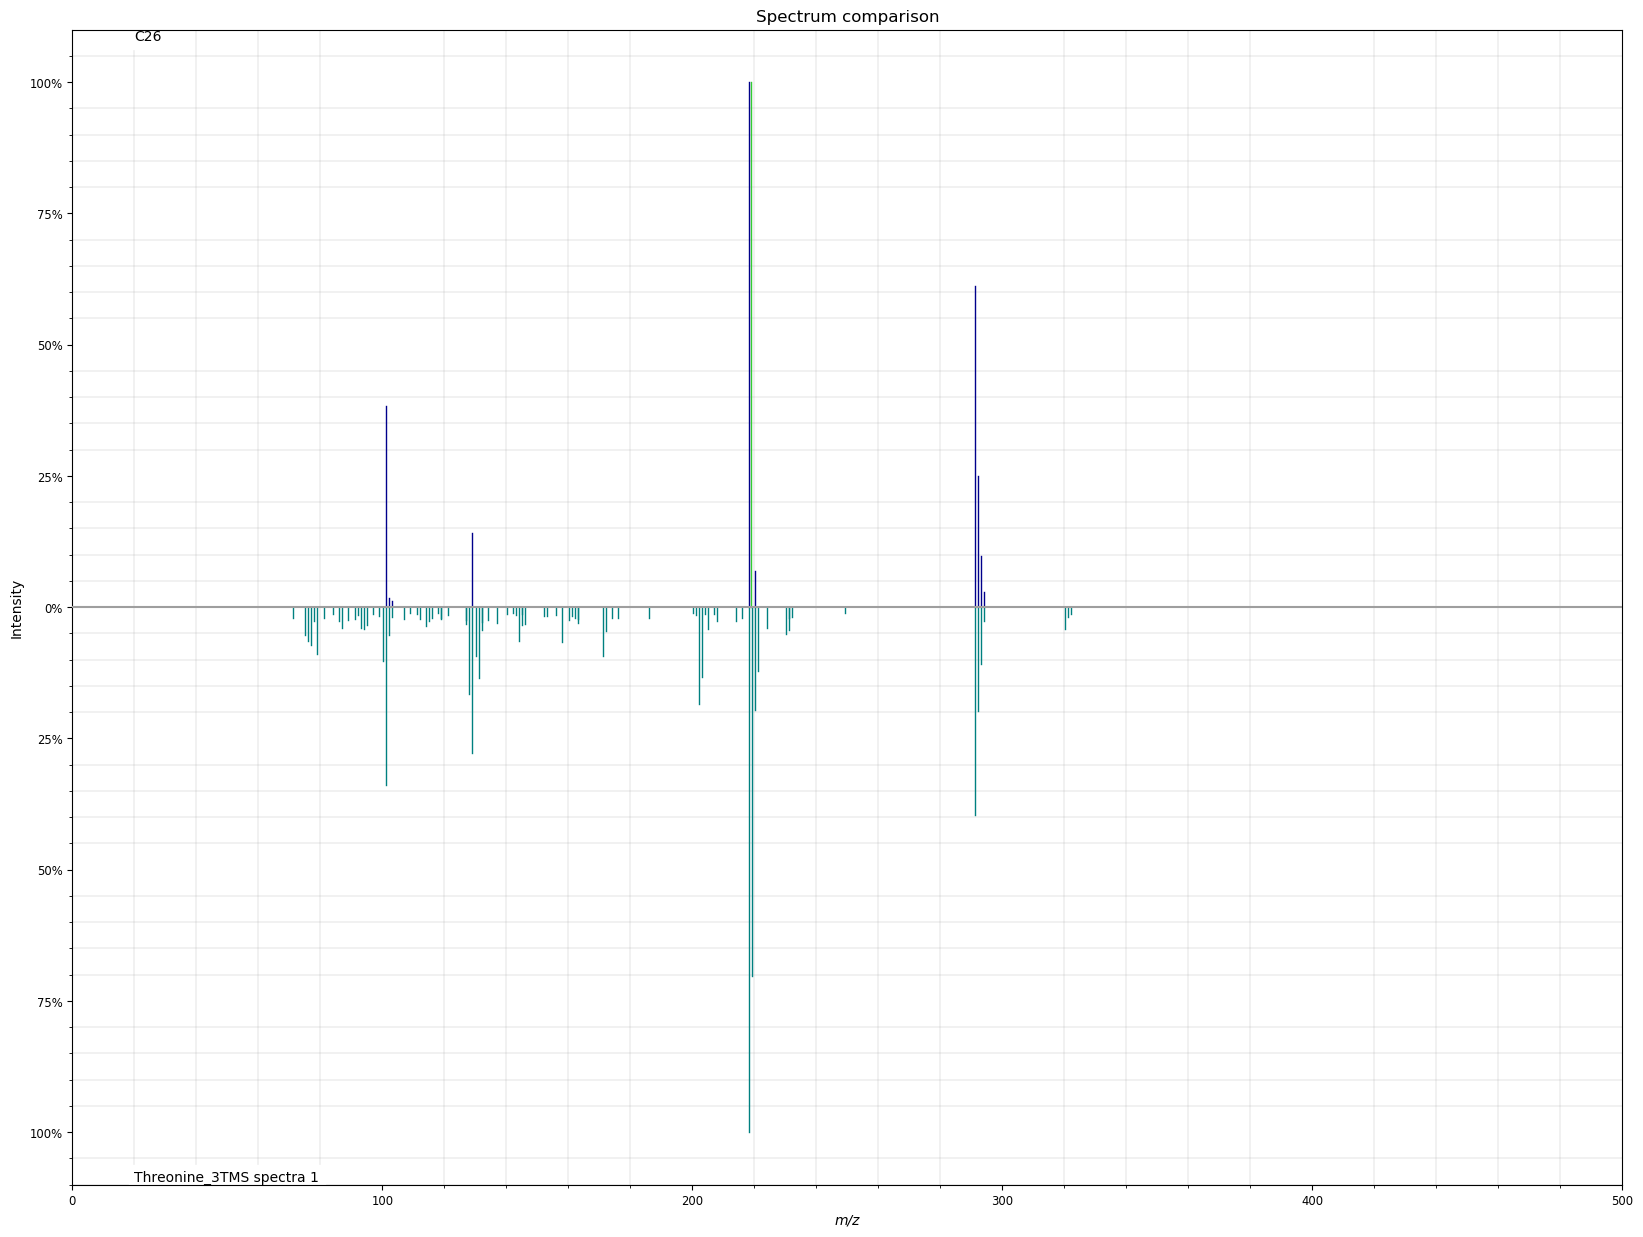

Spectrum C17 - detected peaks: 8
When matched to Serine_3TMS: 8 matched ions with 0.8255728082836913 total confidence
In this match, 0 peaks were not in library spectrum and 24 peaks from library spectrum were missing



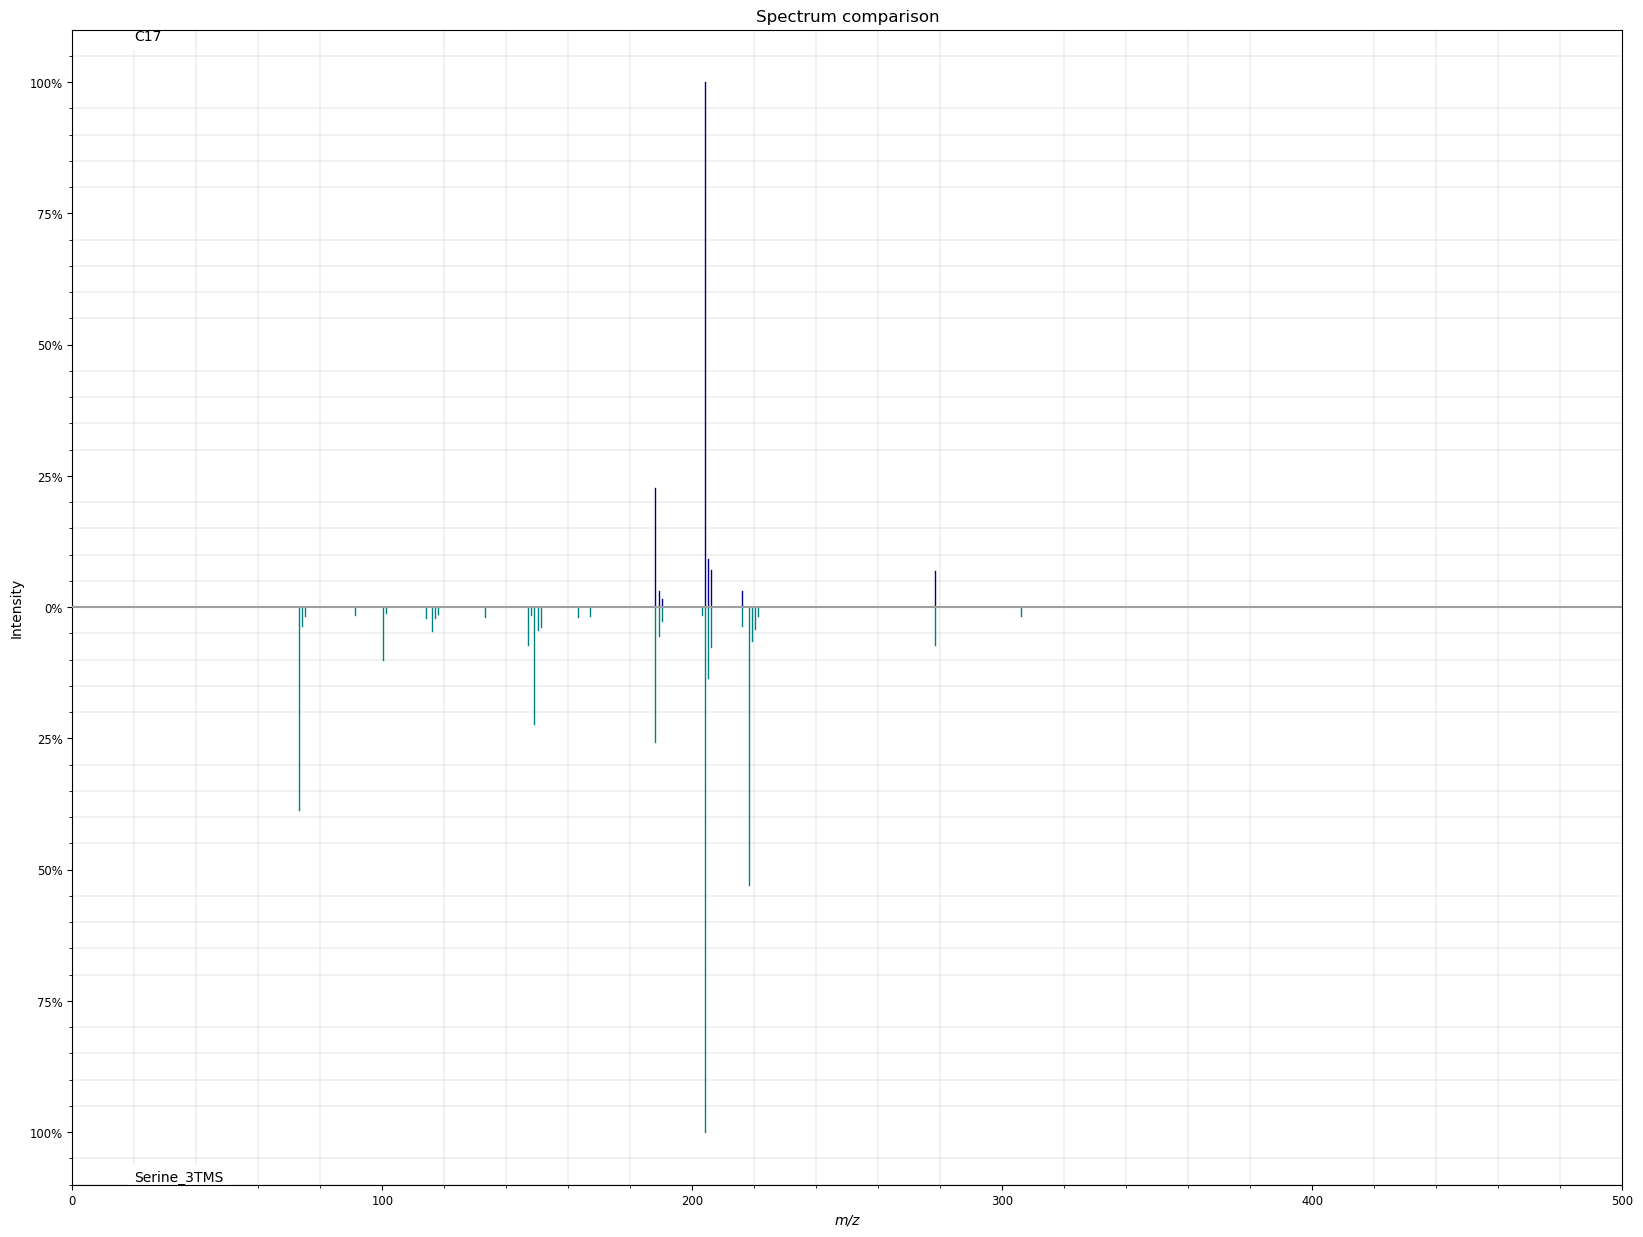

Spectrum C06 - detected peaks: 17
When matched to Ribitol_5TMS: 8 matched ions with 0.7140334223708281 total confidence
In this match, 9 peaks were not in library spectrum and 35 peaks from library spectrum were missing



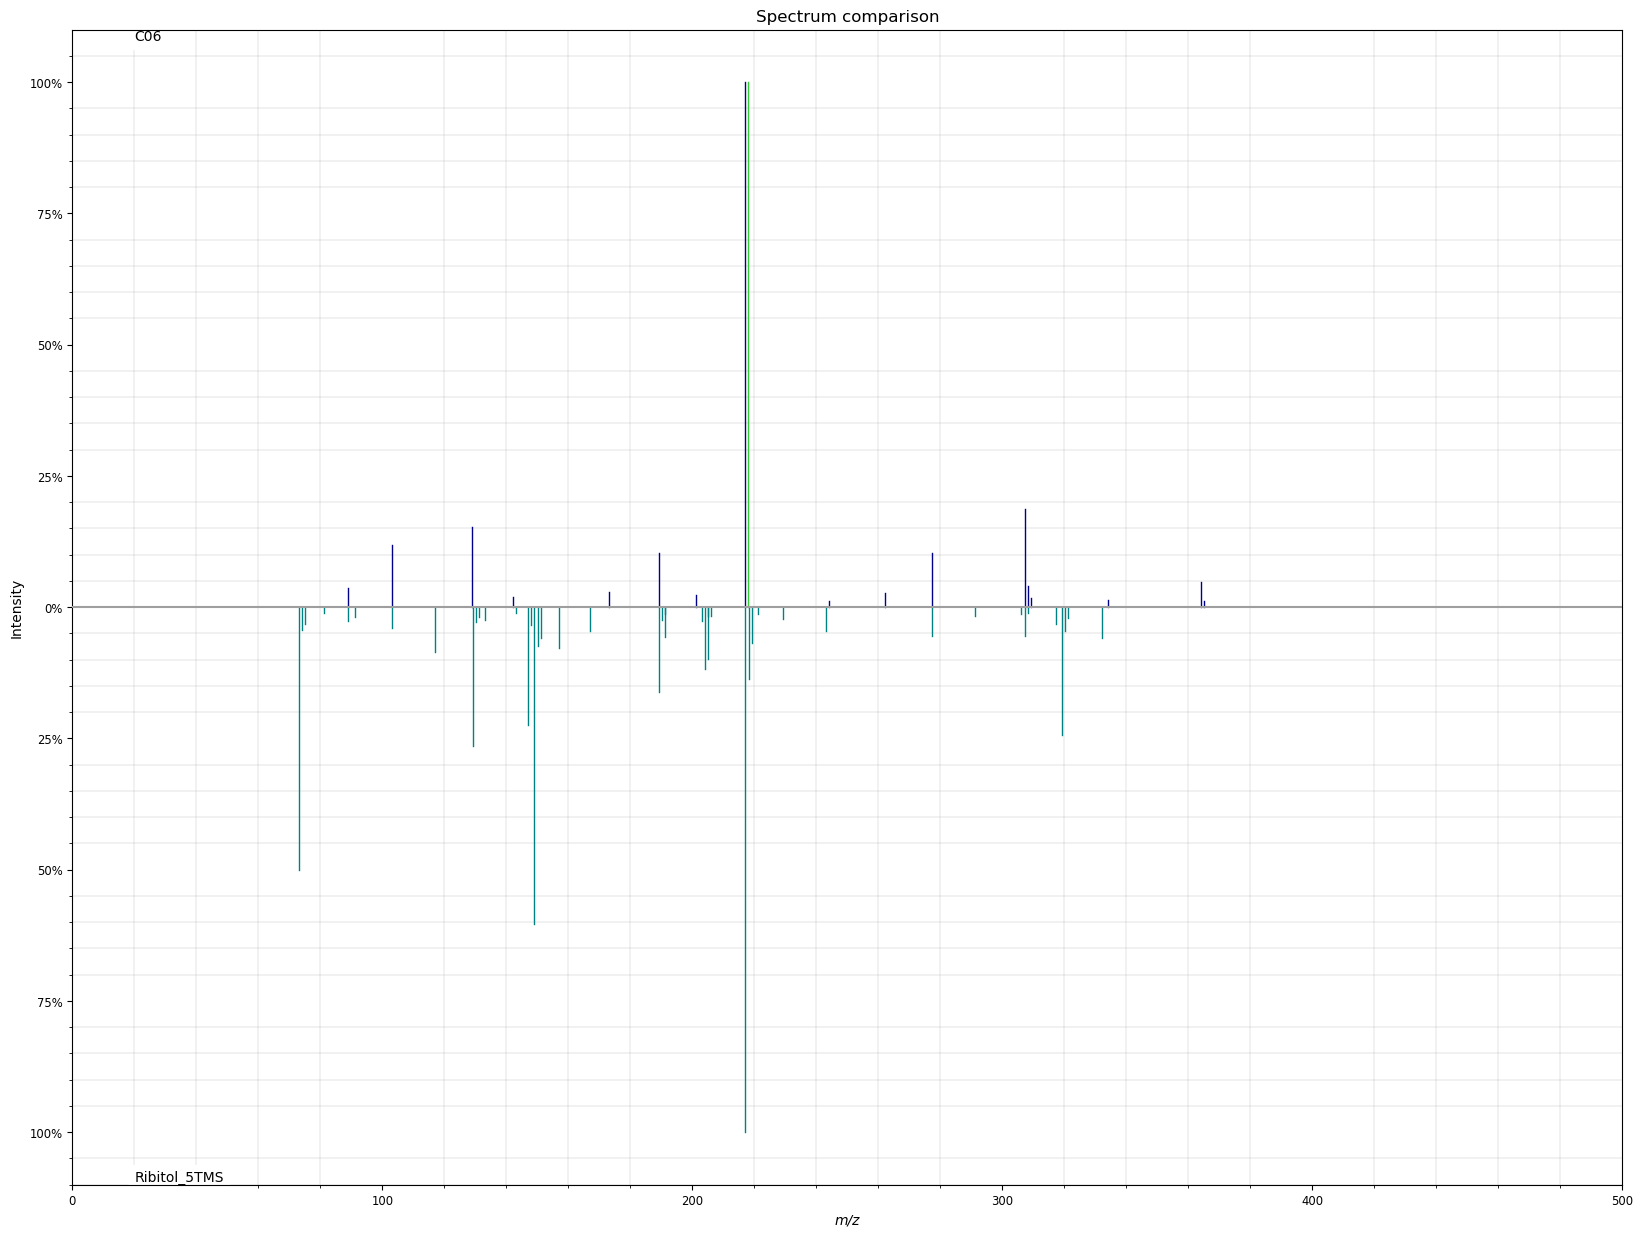

Spectrum C06 - detected peaks: 17
When matched to Gluconic acid-1,4-lactone: 7 matched ions with 0.8218563911271052 total confidence
In this match, 8 peaks were not in library spectrum and 45 peaks from library spectrum were missing



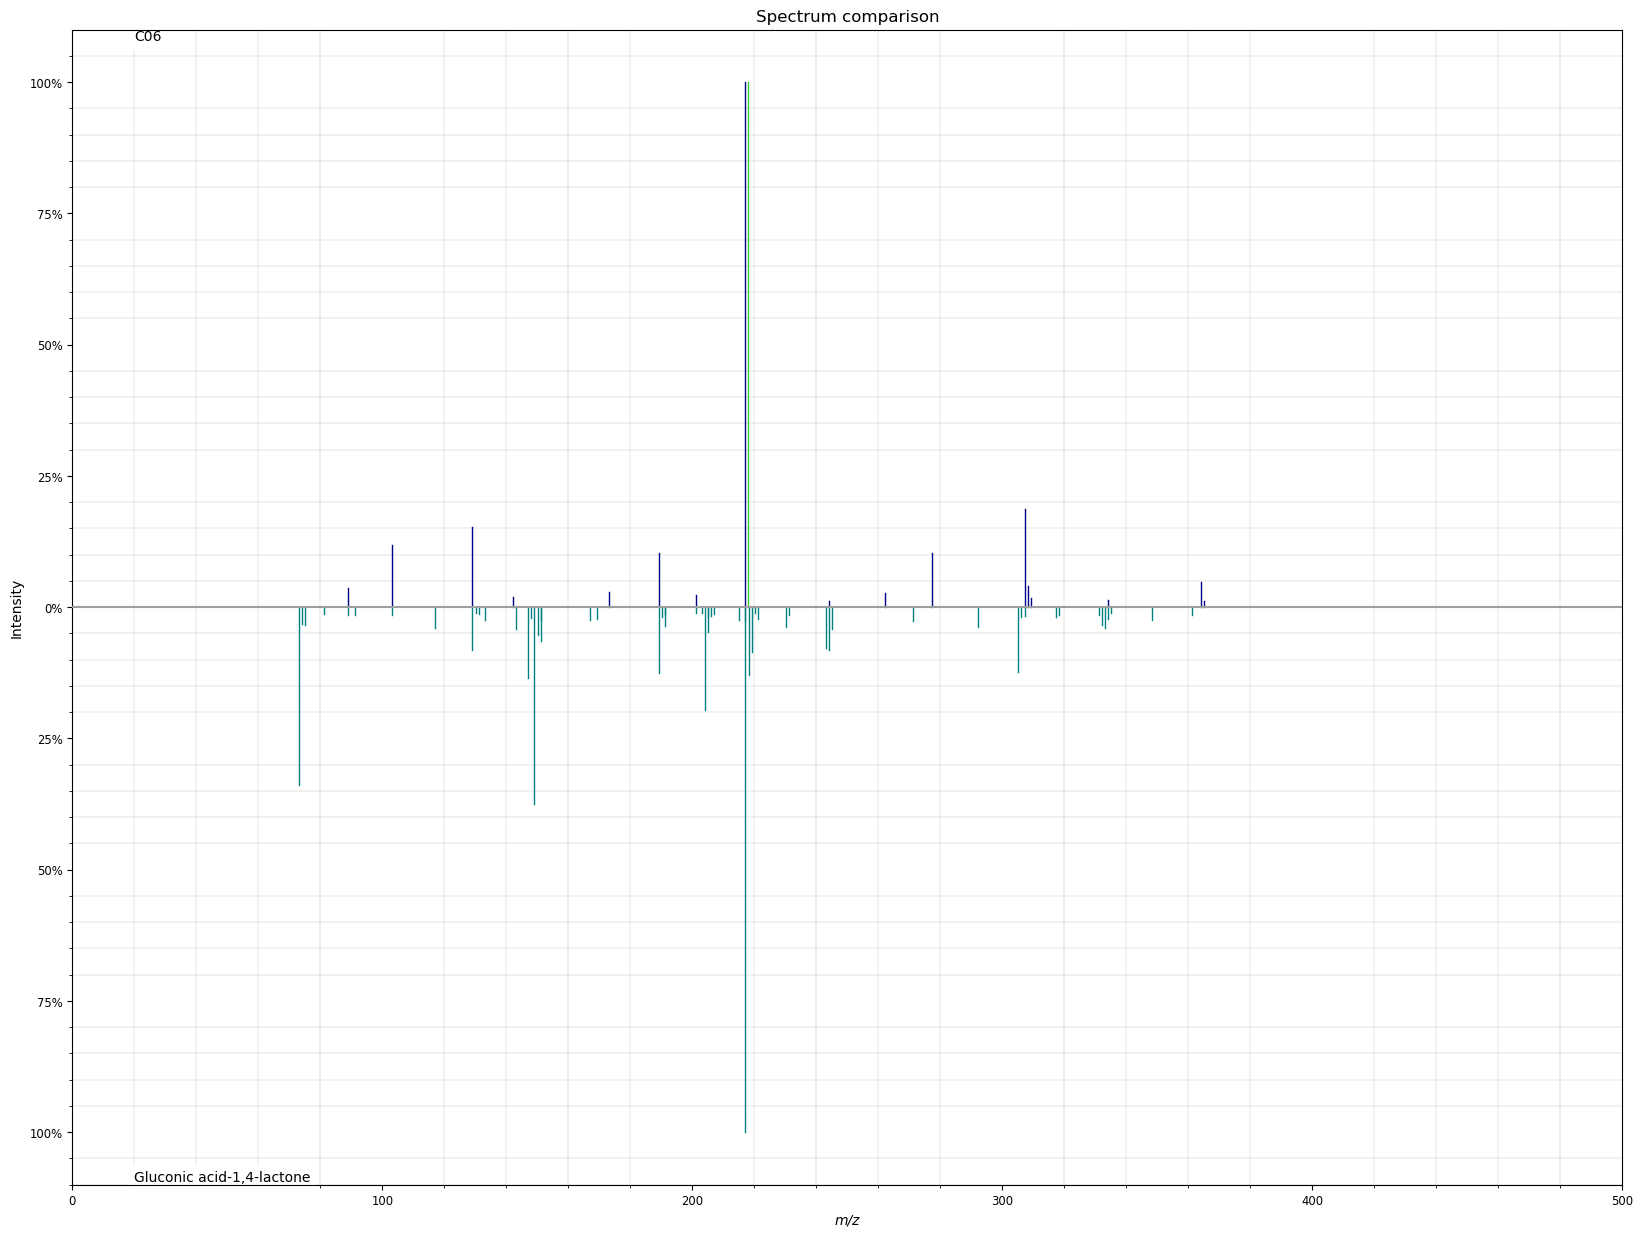

Spectrum C06 - detected peaks: 17
When matched to Galactitol_6TMS: 7 matched ions with 0.7806173392109105 total confidence
In this match, 9 peaks were not in library spectrum and 42 peaks from library spectrum were missing



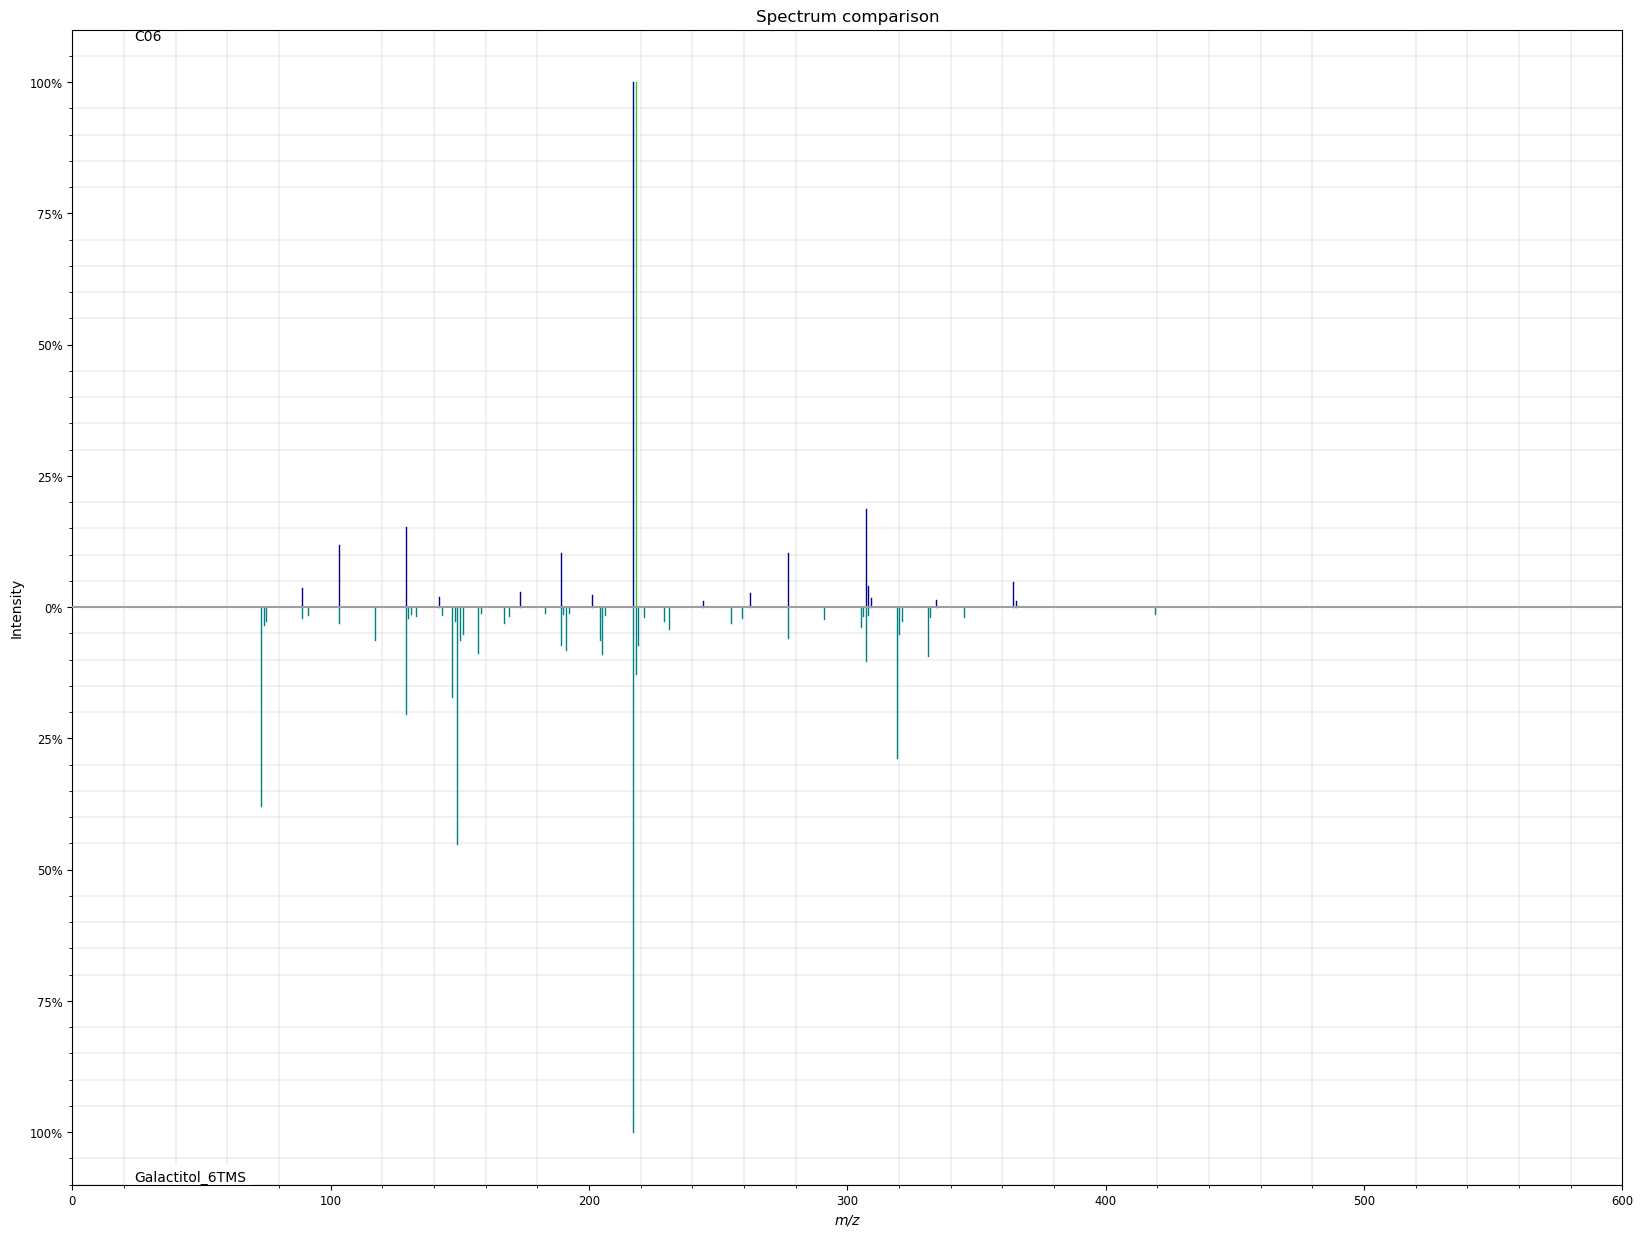

Spectrum C19 - detected peaks: 7
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.8539725938176345 total confidence
In this match, 2 peaks were not in library spectrum and 35 peaks from library spectrum were missing



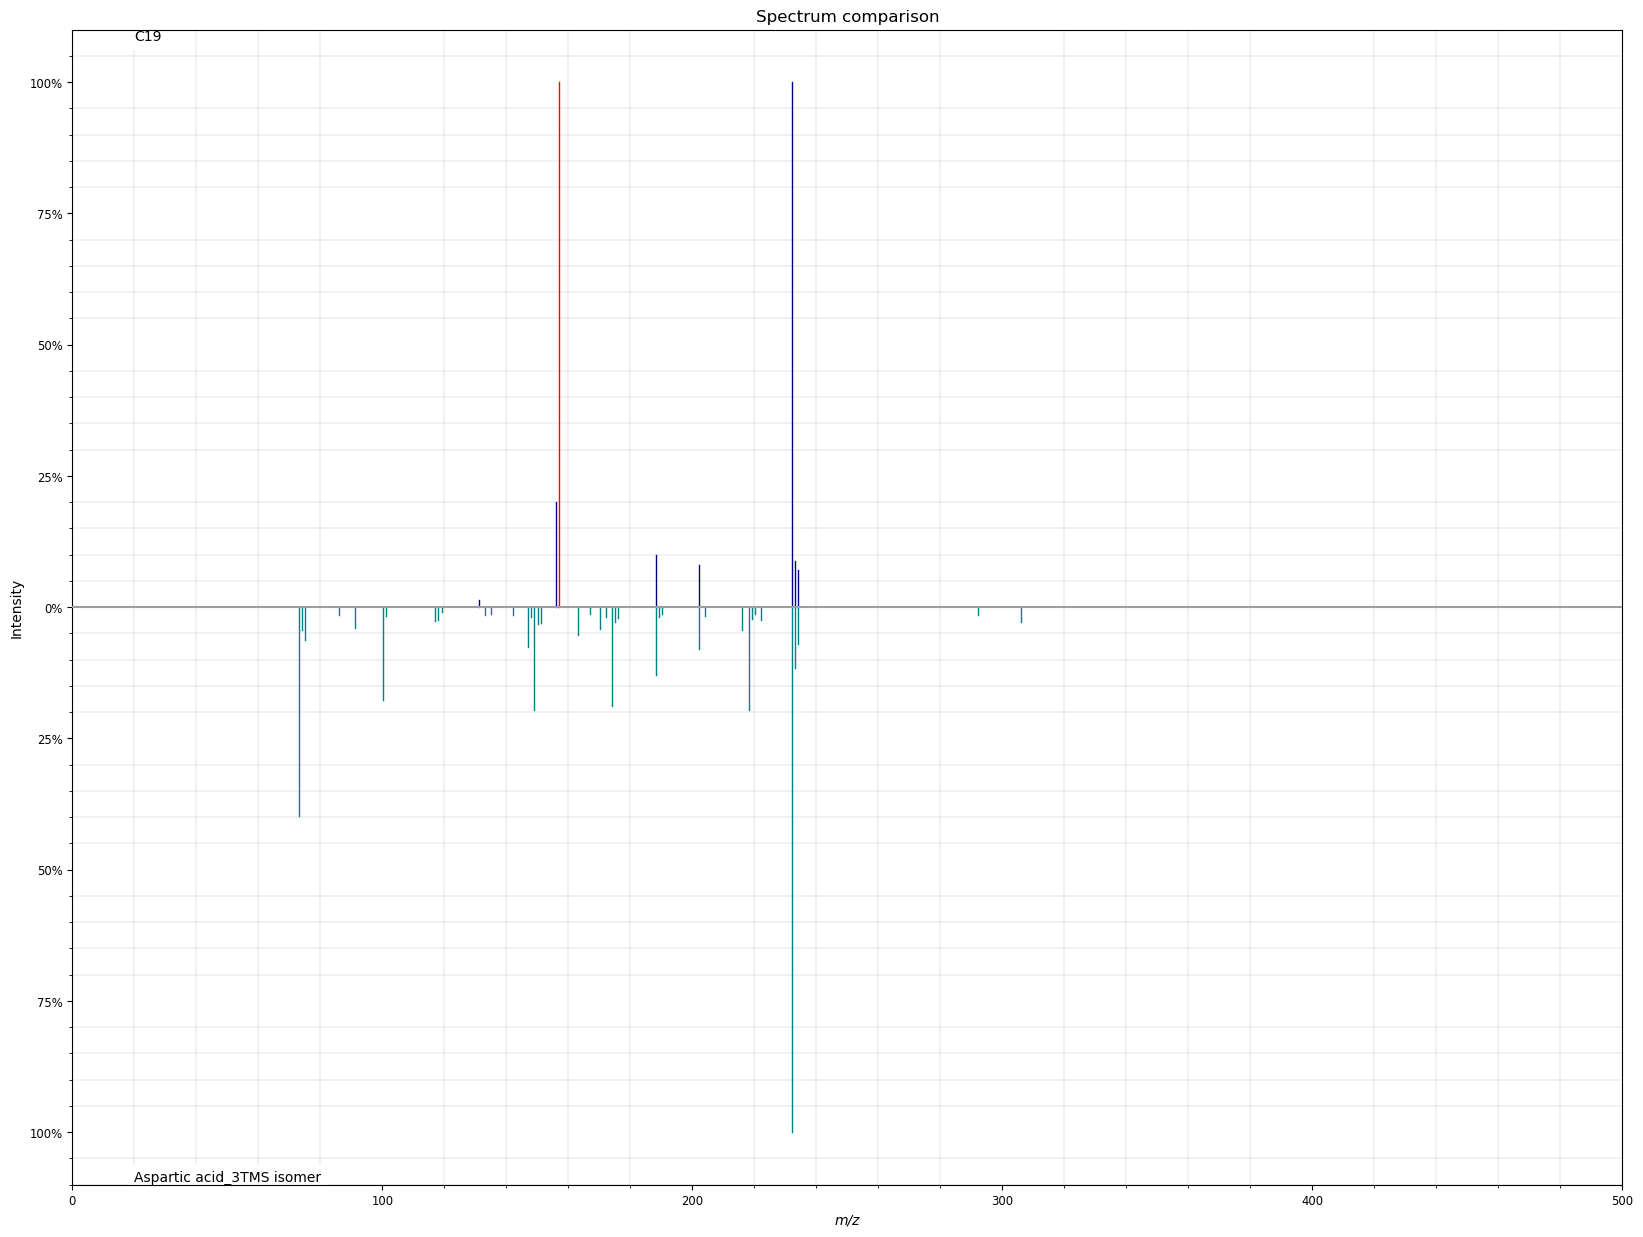

Spectrum C19 - detected peaks: 7
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.9098349214292314 total confidence
In this match, 2 peaks were not in library spectrum and 35 peaks from library spectrum were missing



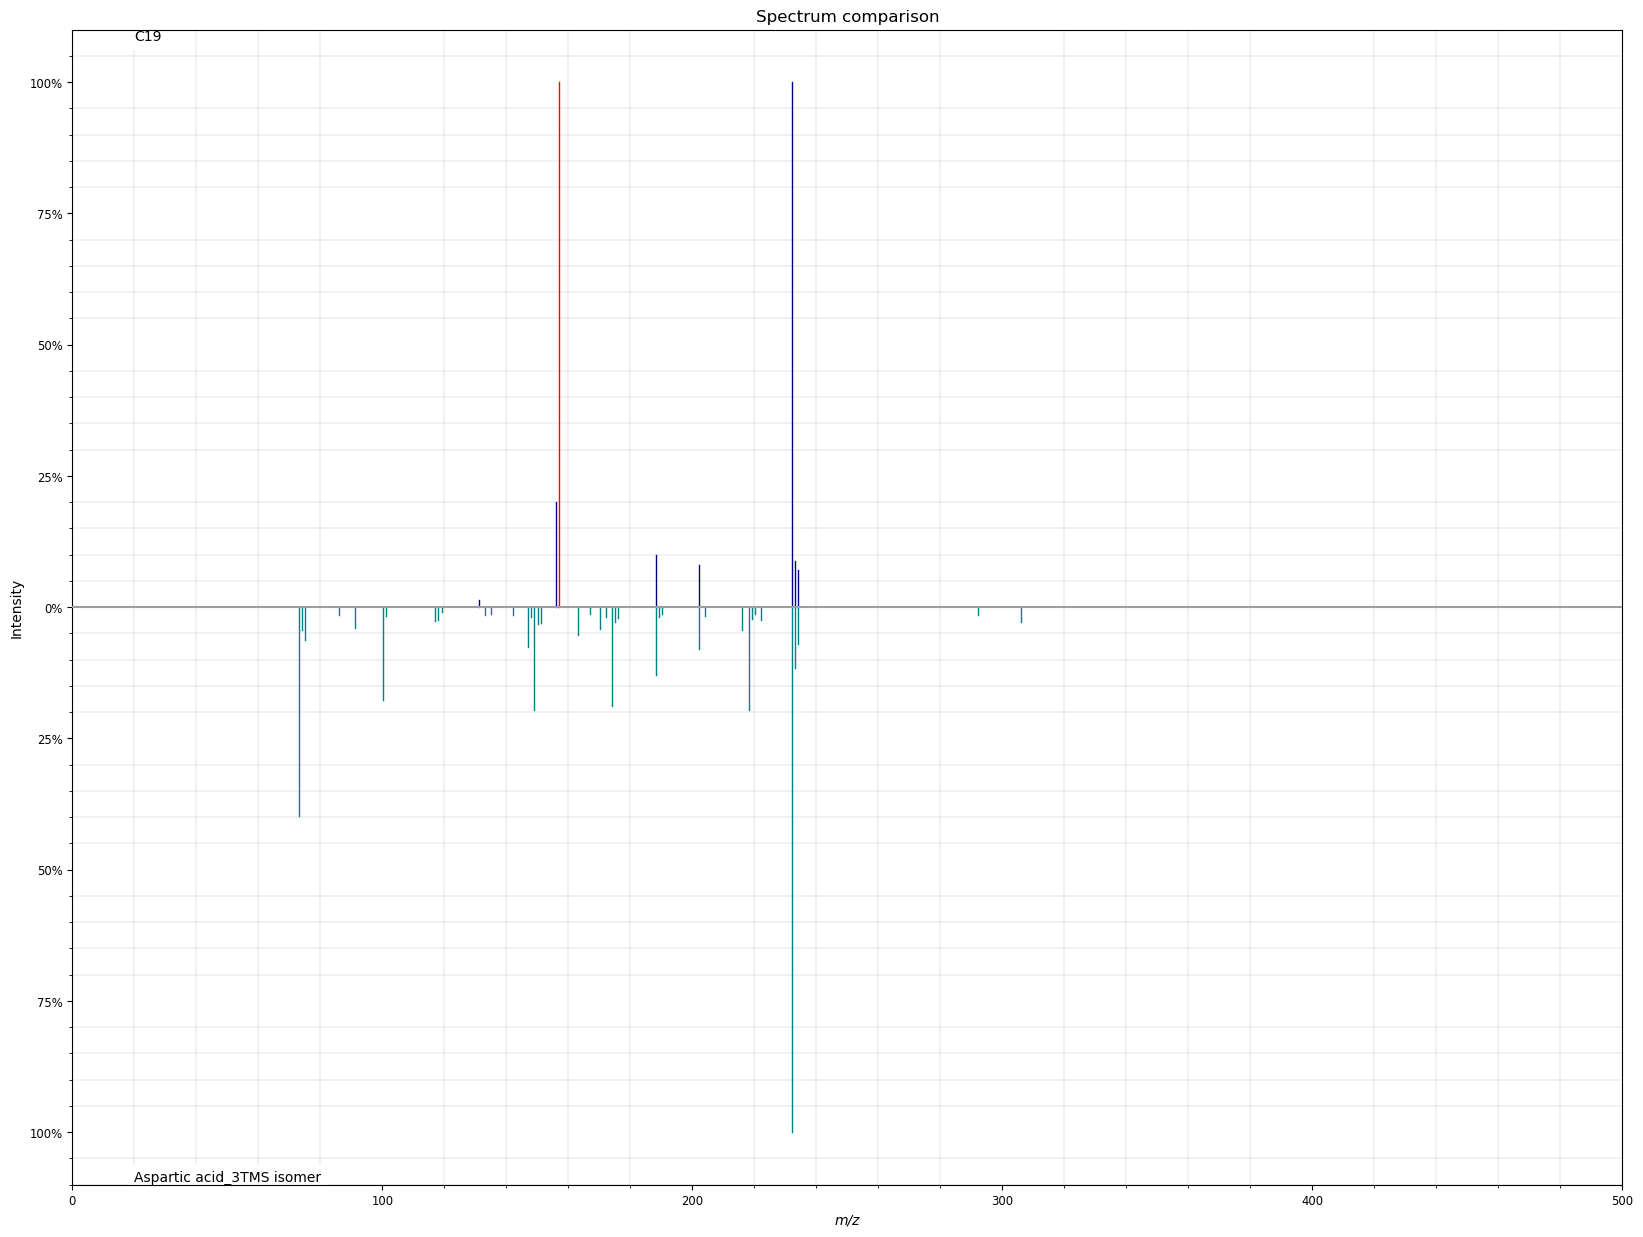

Spectrum C19 - detected peaks: 7
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.8539725938176345 total confidence
In this match, 2 peaks were not in library spectrum and 35 peaks from library spectrum were missing



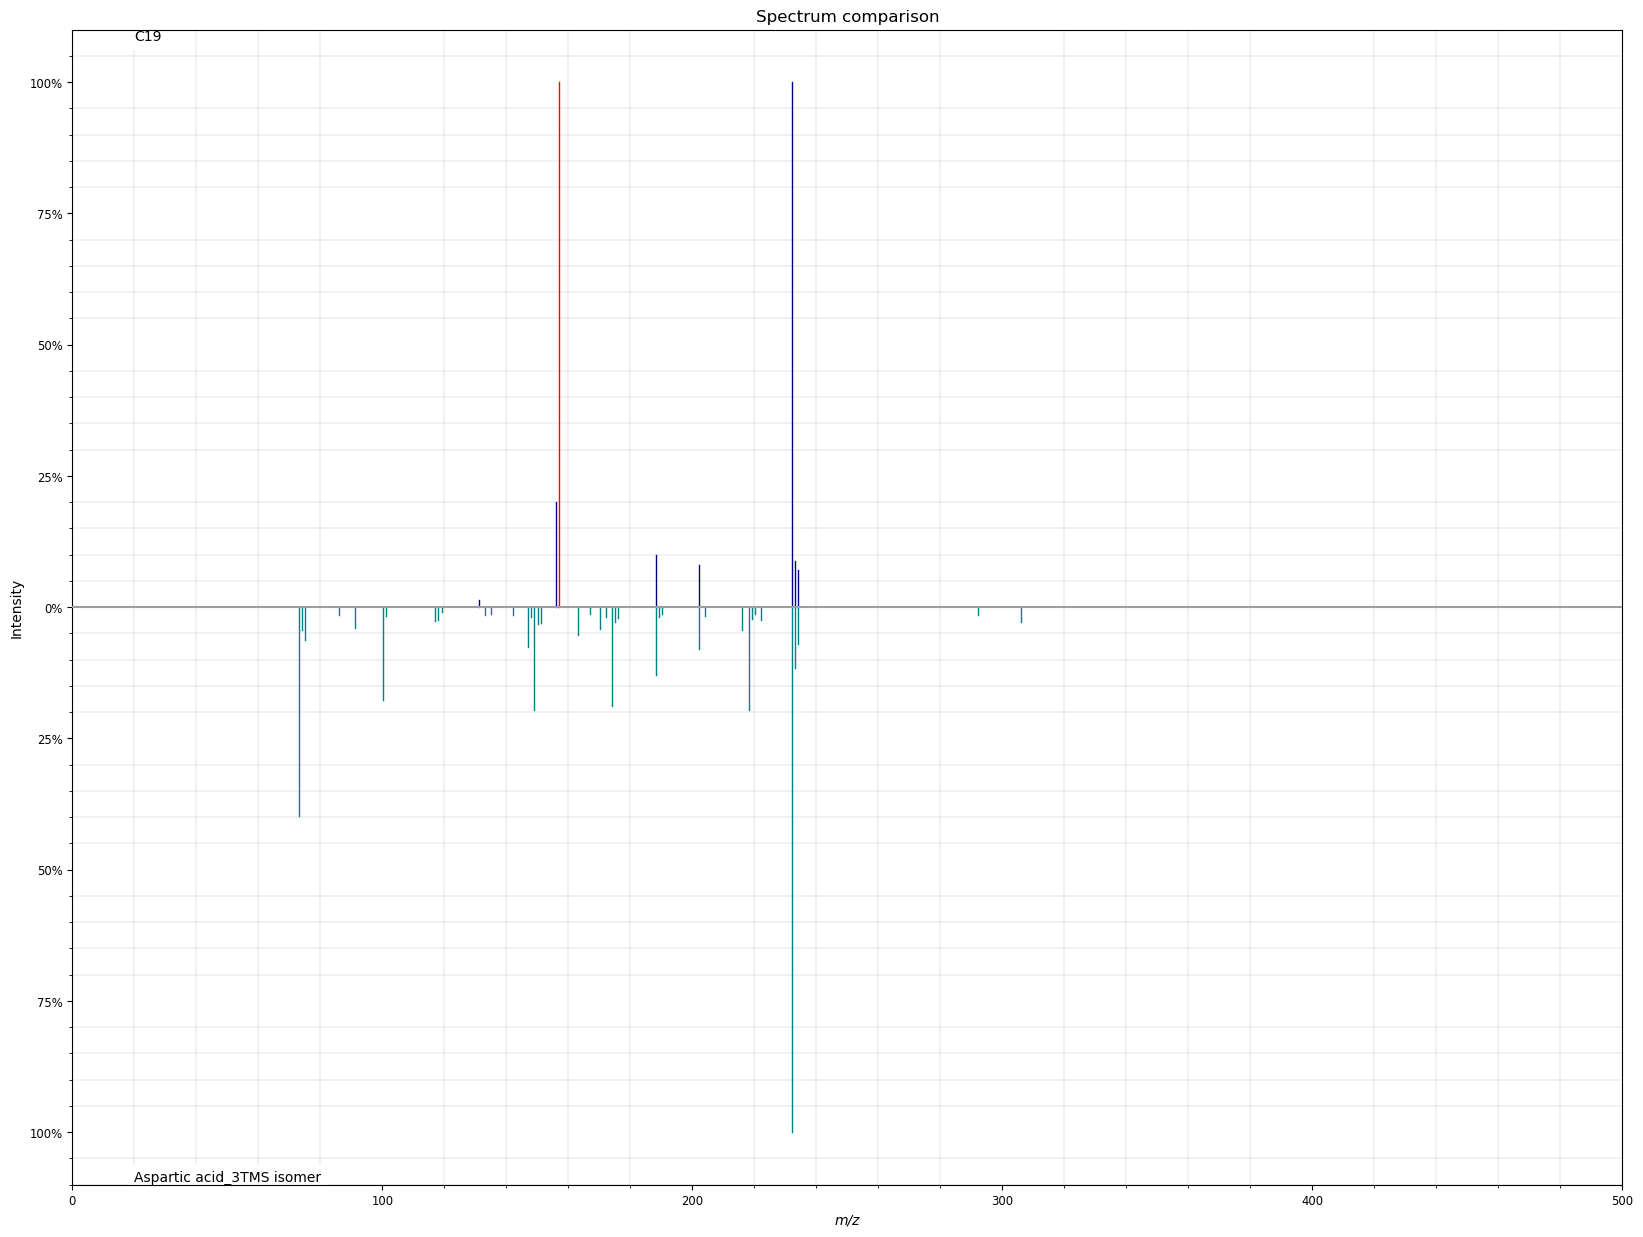

Spectrum C19 - detected peaks: 7
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.9098349214292314 total confidence
In this match, 2 peaks were not in library spectrum and 35 peaks from library spectrum were missing



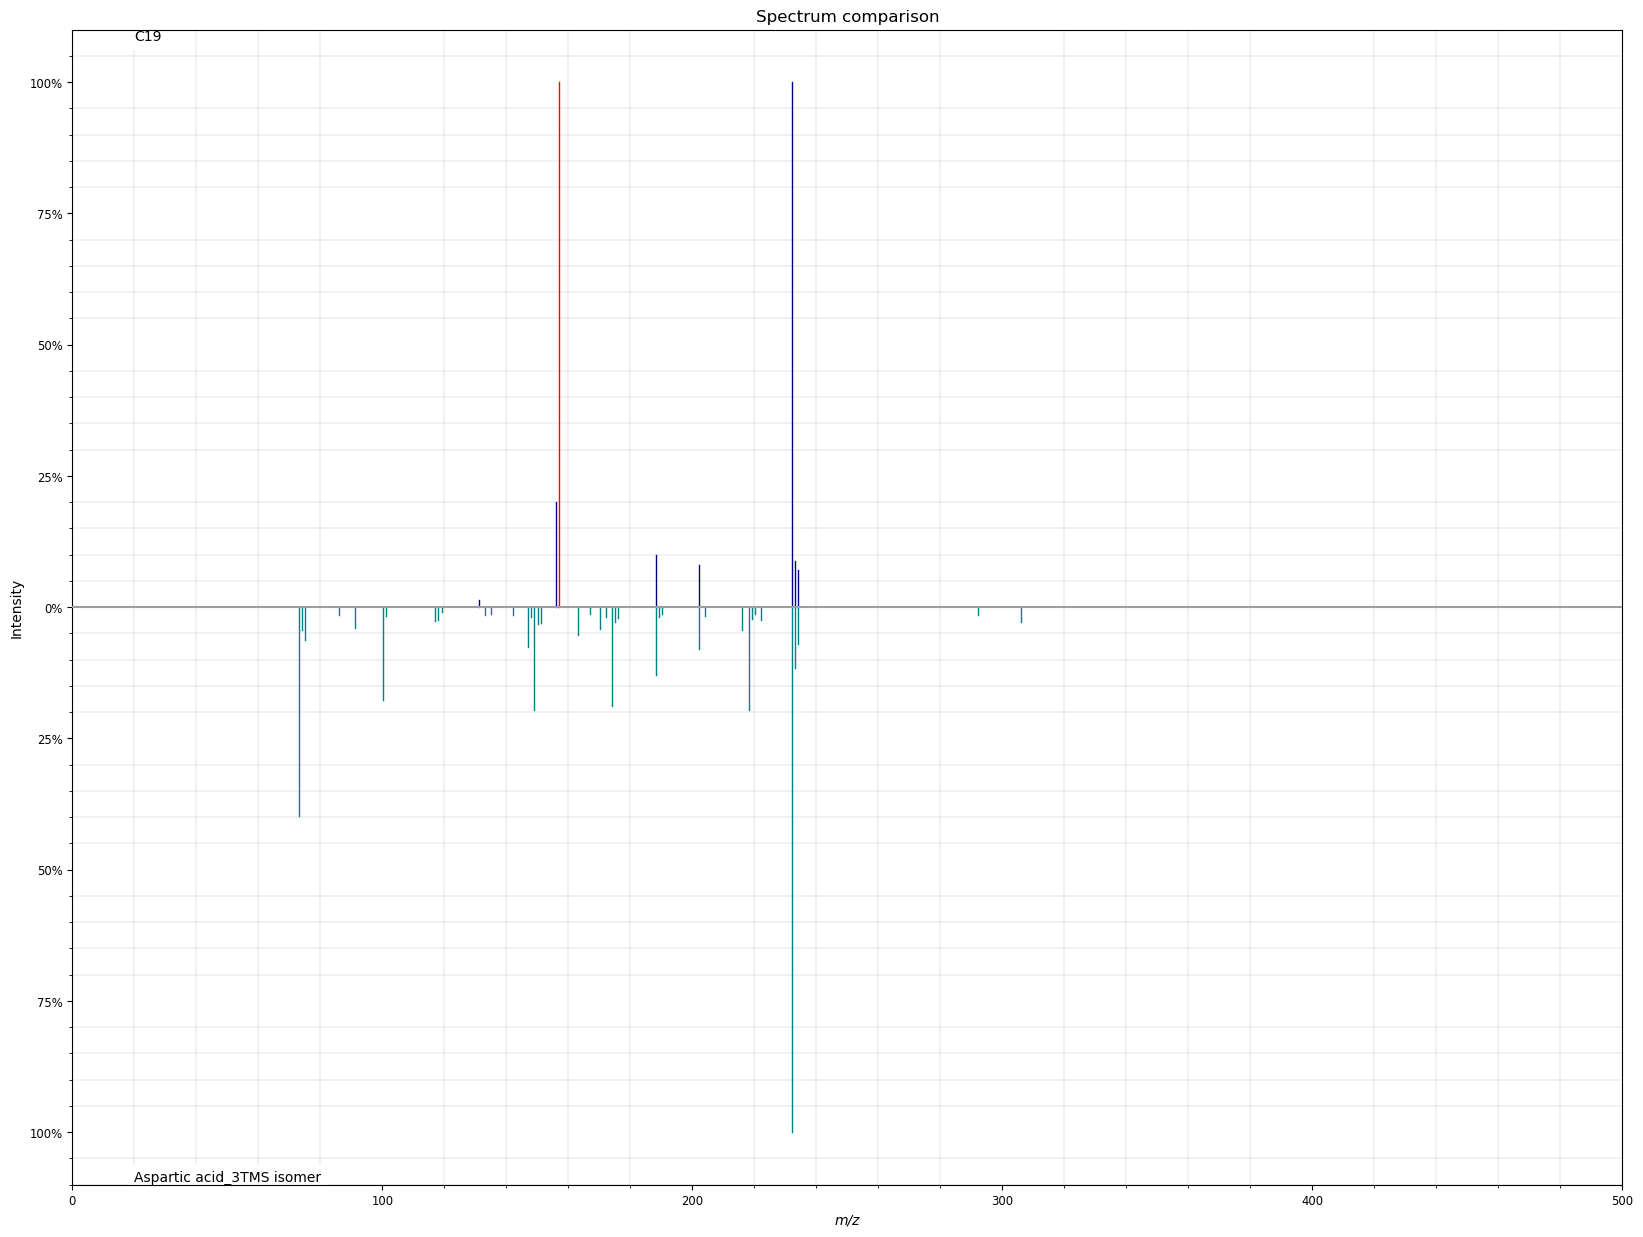

Spectrum C47 - detected peaks: 4
When matched to Norvaline_2TMS: 4 matched ions with 0.9273509946432018 total confidence
In this match, 0 peaks were not in library spectrum and 18 peaks from library spectrum were missing



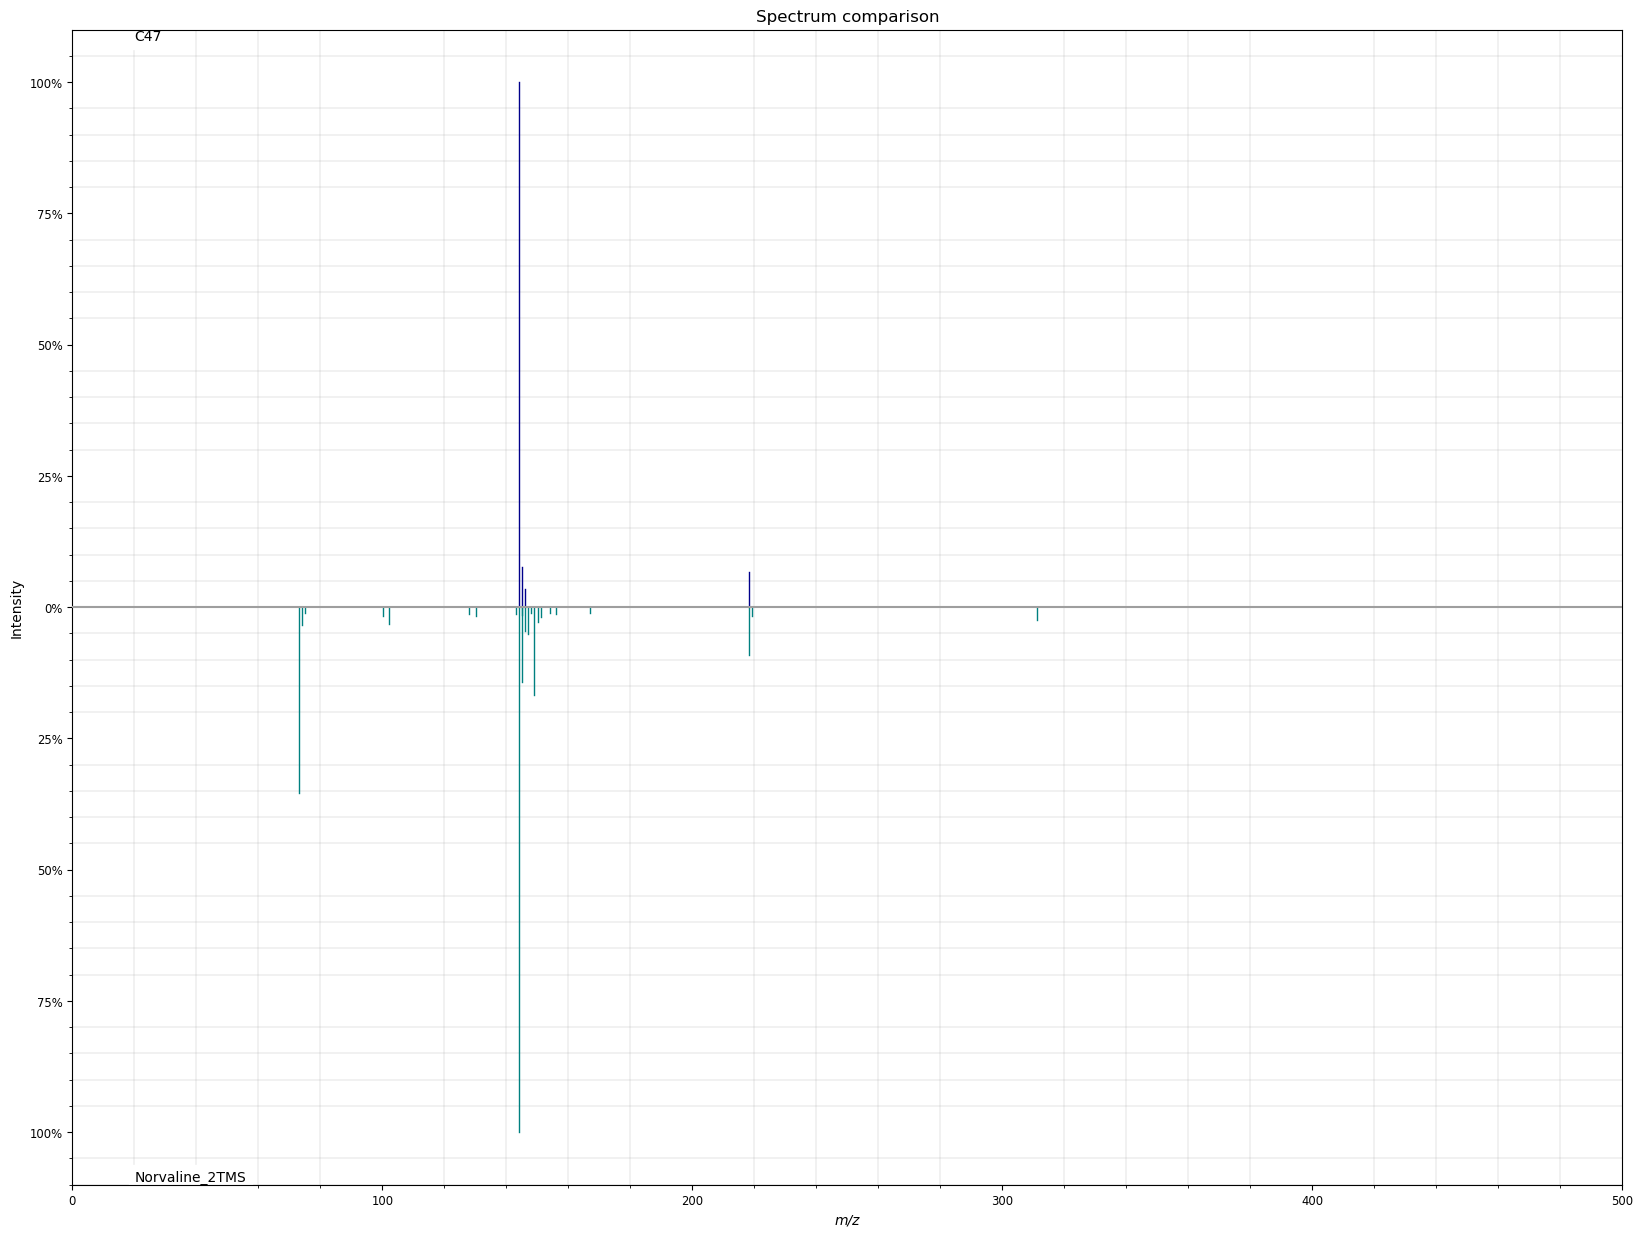

Spectrum C39 - detected peaks: 7
When matched to Histidine_3TMS: 4 matched ions with 0.8396355282325411 total confidence
In this match, 0 peaks were not in library spectrum and 39 peaks from library spectrum were missing



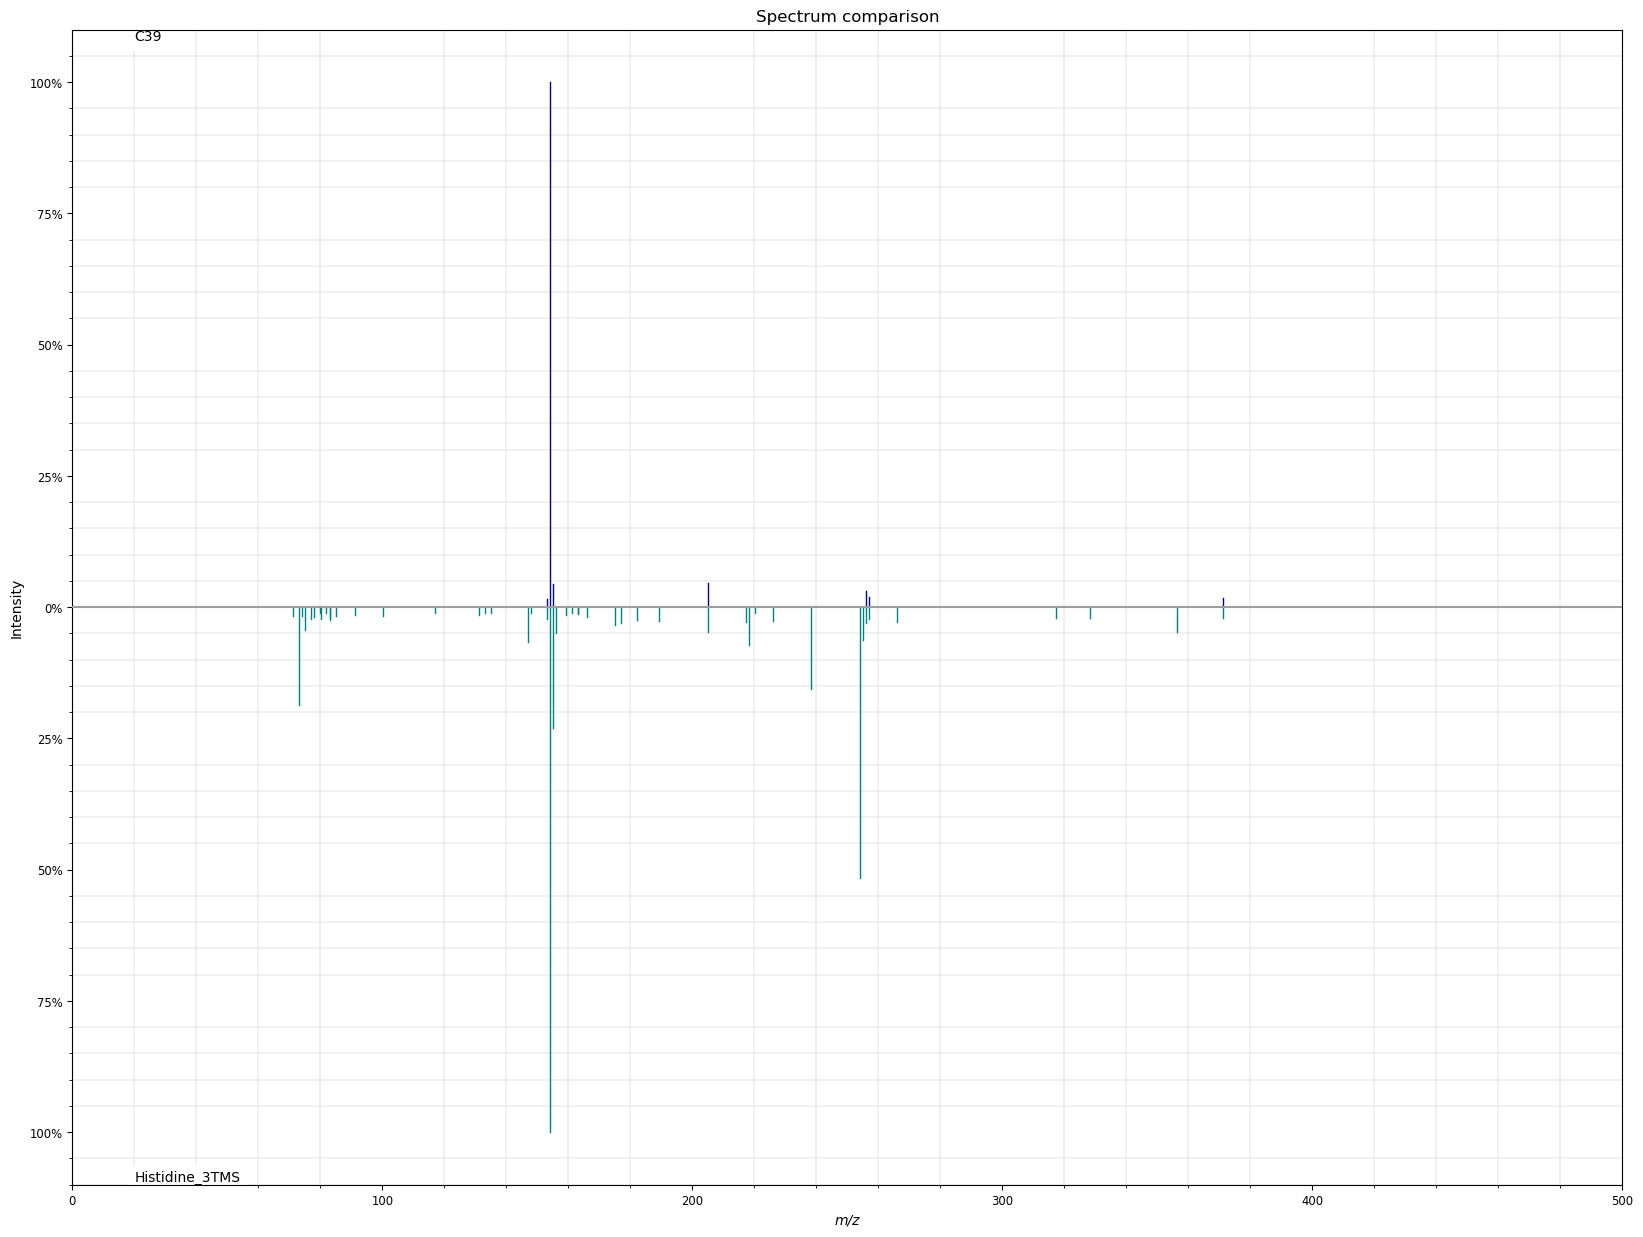

Spectrum C02 - detected peaks: 26
When matched to Pipecolinic acid_2TMS: 4 matched ions with 0.7553661382849925 total confidence
In this match, 20 peaks were not in library spectrum and 8 peaks from library spectrum were missing



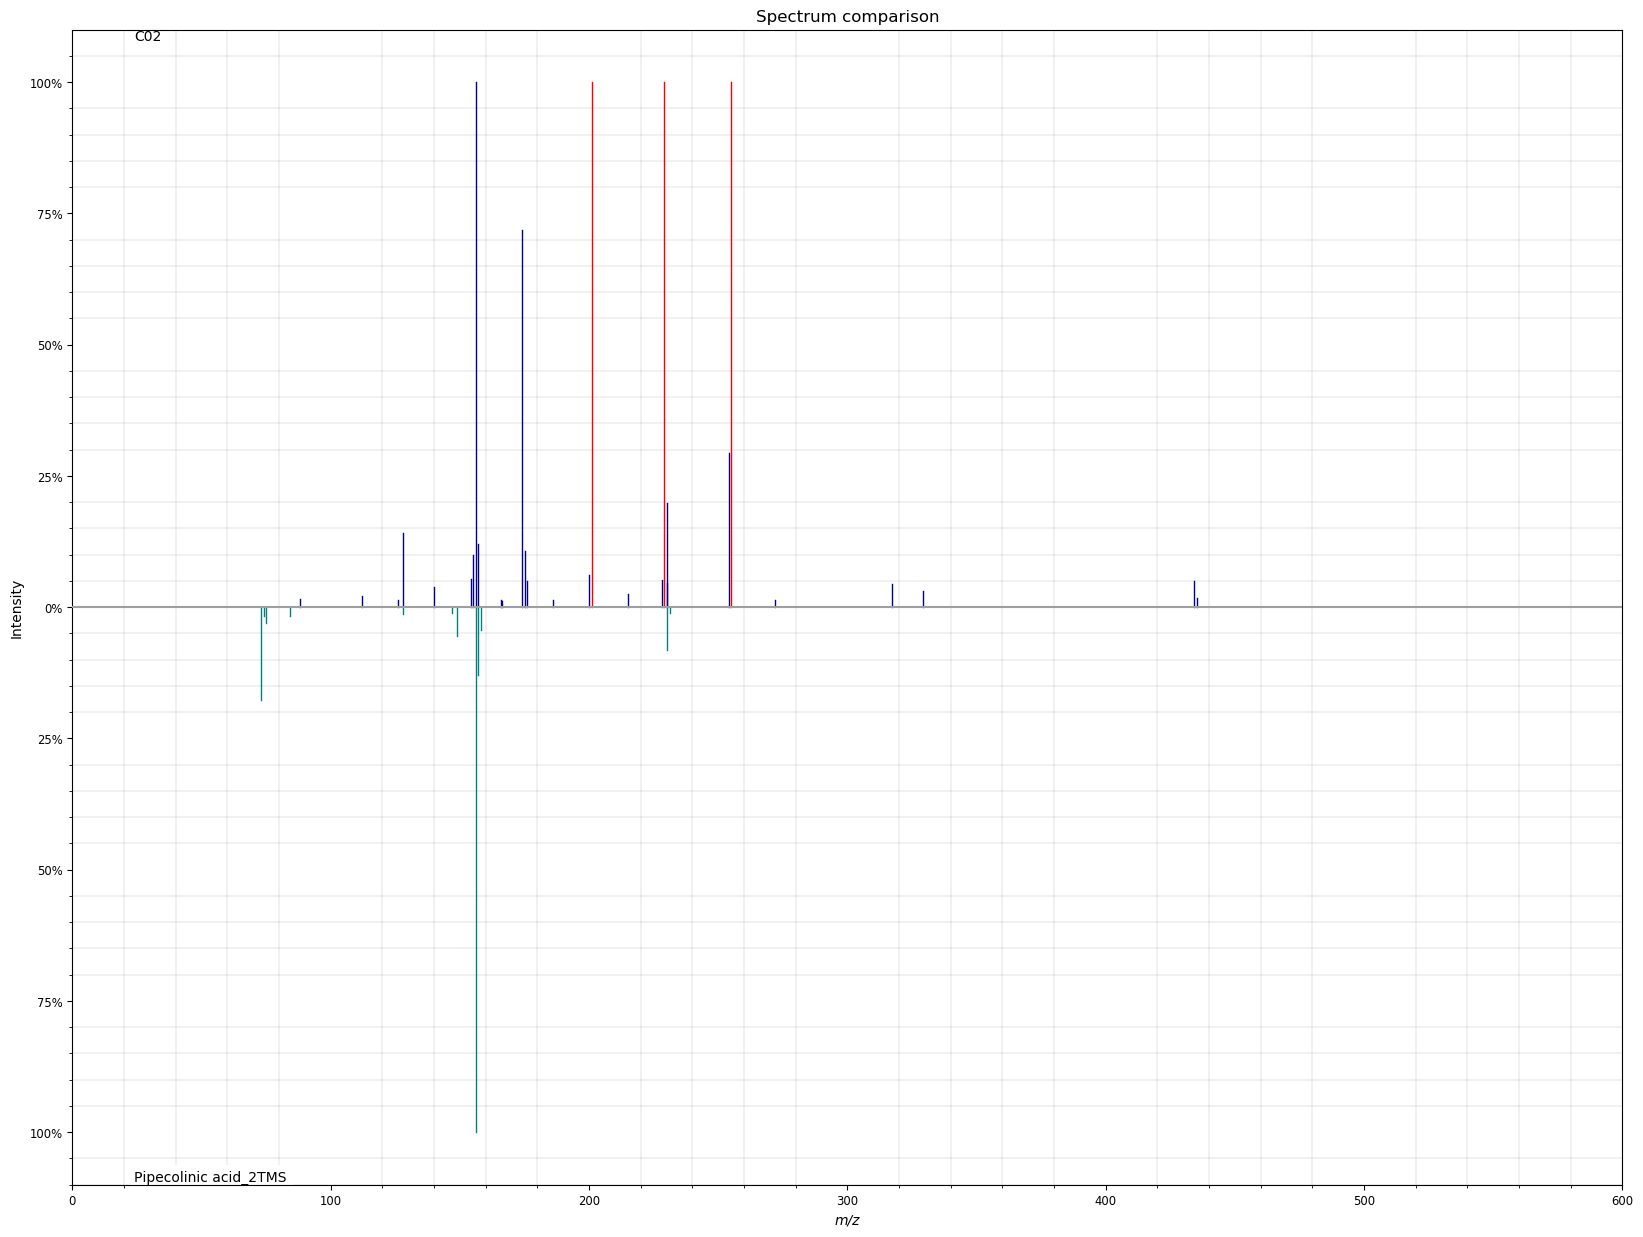

In [320]:
ordered = get_order(matched, conc)
for c in reversed(sorted(ordered, key=lambda x: ordered[x])):
    spec, lib = couple_plot(c[0], measured, library, matched, conc=conc, repetition_count=c[1])
    fig, ax = plt.subplots(1,1,figsize=(10, 6))
    
    if c[0] in measured[conc+"_pred"]:
        corr, wrong = evaluate(measured[conc+"_pred"][c[0]], lib)
        c_s = Spectrum(corr, np.ones_like(corr), metadata_harmonization=False)
        w_s = Spectrum(wrong,  np.ones_like(wrong), metadata_harmonization=False)
        if w_s.peaks:
            ax = plot_spectrum(w_s, ax=ax, peak_color="red", grid=False)
        if c_s.peaks:
            ax = plot_spectrum(c_s, ax=ax, peak_color="limegreen", grid=False)

    ax = plot_spectra_mirror(spec, lib, ax=ax)
    ax.grid(visible=False)

    fig.set_size_inches(20, 15)
    plt.show()

In [19]:
ref = pd.read_csv("../data/11_KC_Confirmed_seminalplasma.csv.csv")
ref

,Average Rt(min),Average RI,Metabolite name
0,2.484,1224.68,2-Methylmalonic acid_2TMS
1,5.333,2071.84,Acetylgalactosamine_4TMS
2,5.318,2065.37,Acetylgalactosamine_5TMS isomer 1
3,5.386,2088.77,Acetylgalactosamine_5TMS isomer 2
4,5.328,2070.17,Acetylglucosamine_5TMS isomer 1
...,...,...,...
60,2.993,1377.14,Threonine_3TMS spectra 1
61,2.996,1378.30,Threonine_3TMS spectra 2
62,4.218,1732.44,trans-Aconitic acid_3TMS
63,5.717,2208.86,Tryptophan_3TMS


In [20]:
matched["all"]

,id,name,n_ions,confidence
1,C02,Lysine_4TMS,23,0.92281020332912
2,C02,Pipecolinic acid_2TMS,4,0.7553661382849925
3,C06,Arabitol_5TMS,9,0.796552247937575
4,C06,Arabitol_5TMS,9,0.7972294938455029
5,C06,Arabitol_5TMS,10,0.796552247937575
6,C06,Arabitol_5TMS,10,0.7972294938455029
7,C06,Fructose_5TMS isomer 1,15,0.8584115640959713
8,C06,Fructose_5TMS isomer 2,18,0.8766808769415186
9,C06,Galactitol_6TMS,7,0.7806173392109105
10,C06,"Gluconic acid-1,4-lactone",7,0.8218563911271052


In [21]:
ground = set(ref["Metabolite name"])
pred = set(matched["all"].name) 

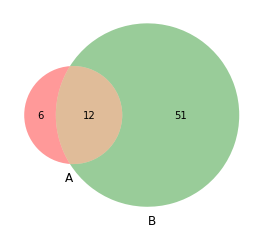

In [22]:
from matplotlib_venn import venn2
venn2((pred, ground))

In [23]:
from matchms import calculate_scores
from matchms.similarity import CosineHungarian

scores_orig = calculate_scores(
        references=list(library.values()),
        queries=list(measured["all"].values()),
        similarity_function=CosineHungarian(tolerance=0.1),
        is_symmetric=False
    )


In [27]:
# MISSING RI FILTERING AND HI-RES STEP
scores = calculate_scores(
        references=list(library.values()),
        queries=list(measured["all_enh"].values()),
        similarity_function=CosineHungarian(tolerance=0.003),
        is_symmetric=False
    )

In [28]:

def get_outputs(args, scores):
    print("Storing outputs...")
    query_names = [spectra.metadata['compound_name'] for spectra in scores.queries]
    reference_names = [spectra.metadata['compound_name'] for spectra in scores.references]

    # Write scores to dataframe
    dataframe_scores = pd.DataFrame(data=[entry["score"] for entry in scores.scores], index=reference_names, columns=query_names)
    #dataframe_scores.to_csv(args.output_filename_scores, sep='\t')

    # Write number of matches to dataframe
    dataframe_matches = pd.DataFrame(data=[entry["matches"] for entry in scores.scores], index=reference_names, columns=query_names)
    #dataframe_matches.to_csv(args.output_filename_matches, sep='\t')

    return dataframe_scores, dataframe_matches

In [29]:
sc, m = get_outputs(None, scores)
sc_, m_ = pd.read_csv(get_galaxy_filename('CosineHungarian scores', '../data'), sep="\t", index_col=0),  pd.read_csv(get_galaxy_filename('CosineHungarian matches', '../data'), sep="\t", index_col=0)

Storing outputs...


In [30]:
m_.index

Index(['Acetylserotonin_2TMS isomer 2', 'Acetylserotonin_TMS derivative',
       'Acetylserotonin_3TMS', 'Acetylserotonin_2TMS isomer 1',
       'Methylnicotinamide', 'Pipecolinic acid_2TMS', 'Pipecolinic acid_1TMS',
       'Nicotinic acid_1TMS', 'Ribose_4TMS', 'Syringic acid_2TMS',
       ...
       '5-Methylcytidine_4TMS isomer 2', 'Acetylaspartic acid_2TMS',
       'Threonine_3TMS spectra 1', '2-Oxoadipic acid_2TMS isomer 2',
       '2-Oxoadipic acid_2TMS isomer 1', 'Cytidine_4TMS',
       'Dehydrocholesterol_1TMS', 'Dehydroergosterol_1TMS',
       'Cholestatrienol_1TMS', 'Proline_2TMS'],
      dtype='object', length=265)

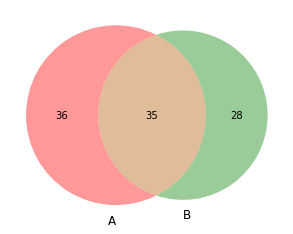

In [84]:
p = set(m.index[((m > 3) & (sc > 0.18)).any(axis=1)])
venn2((p, ground))

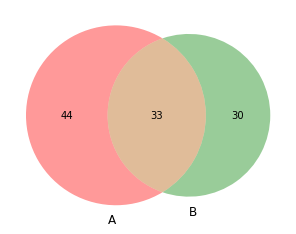

In [83]:
p_ = set(m_.index[((m_ > 3) & (sc_ > 0.2)).any(axis=1)])
venn2((p_, ground))

In [85]:
w = 0.5

def cf(s1, s2):
    return len(s1.intersection(s2)), len(s1.difference(s2)), len(s2.difference(s1))

orig = np.zeros(shape=(20, 10))
new = orig.copy()
for i, n_m in enumerate(range(1,21)):
    for j, n_s in enumerate(np.arange(0,1,0.1)):
        p_orig = set(m_.index[((m_ > n_m) & (sc_ > n_s)).any(axis=1)])
        p_new = set(m.index[((m > n_m) & (sc > n_s)).any(axis=1)])
        
        TP1, FP1, FN1 =  cf(p_orig, set(ground))
        TP2, FP2, FN2 =  cf(p_new, set(ground))
        orig[i,j] = TP1/(TP1 + w*FP1 + (1-w)*FN1) if (TP1 + w*FP1 + (1-w)*FN1) != 0 else 0
        new[i,j] = TP2/(TP2 + w*FP2 + (1-w)*FN2) if (TP2 + w*FP2 + (1-w)*FN2) != 0 else 0
        

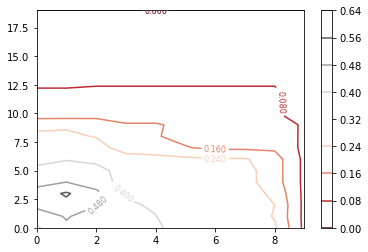

In [86]:
c = plt.contour(new, cmap='RdGy')
plt.clabel(c, inline=True, fontsize=8)

plt.colorbar()

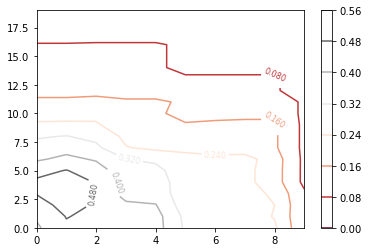

In [87]:
c = plt.contour(orig, cmap='RdGy')
plt.clabel(c, inline=True, fontsize=8)

plt.colorbar()


In [88]:
new.sum(), orig.sum()

(33.52294779297029, 37.630986297918795)

In [89]:
new.max(), orig.max()

(0.5692307692307692, 0.5354330708661418)

In [32]:
assert False

AssertionError: 

In [9]:
!pwd

/mnt/volume/shared/ces-nya/nfs4/home/umsa/job_working_directory_object/033/33254/working/jupyter/raims


In [31]:
conc = "all"

## Experiment 1 - take the compounds and observe

In [12]:
def couple_plot(meas_id, measured, library, matched, conc="0", repetition_count=0):
    spec, lib = couple(meas_id, measured, library, matched, conc=conc, repetition_count=repetition_count)
    
    if lib is not None:
        false_detected = set(spec.peaks.mz.astype(int)).difference(set(lib.peaks.mz.astype(int)))
        missing_mz = set(lib.peaks.mz.astype(int)).difference(set(lib.peaks.mz.astype(int)).intersection(set(spec.peaks.mz.astype(int))))
        print(f"Spectrum {meas_id} - detected peaks: {len(spec.peaks.mz)}")
        print(f"When matched to {lib.metadata['compound_name']}: {matched[conc][matched[conc].id==meas_id].n_ions.values[repetition_count]} matched ions with {matched[conc][matched[conc].id==meas_id].confidence.values[repetition_count]} total confidence")
        print(f"In this match, {len(false_detected)} peaks were not in library spectrum and {len(missing_mz)} peaks from library spectrum were missing")
        plot_spectrum_sample_prediction(lib, missing_mz, [], false_detected, [])
        print()
    return spec, lib


In [ ]:
from collections import defaultdict

repetition_counter = defaultdict(lambda: 0)

for meas_id in matched[conc].id:
    spec, lib = couple_plot(meas_id, measured, library, matched, conc=conc, repetition_count=repetition_counter[meas_id])
    #plot_spectrum_sample_prediction(measured[conc][meas_id], [], [], [], [])
    spec.plot_against(lib, figsize=(8, 6))
    plt.show()
    
    repetition_counter[meas_id] += 1

## Observation
There is a clear trend of very few peaks detected. Also, however, this is a sample WITHOUT dilution. Although in over 50% of compounds, the most abundat peak is matched, the rest of the peaks is by no means behaving as we thought( few highmost detected). Rather, the peaks tend to be quite small.  

IMHO it is caused by many false matches (the 3 matching an 30% is prolly too relaxed setting), and the matched compounds does NOT correspond to the compounds in the measured sample. 

## Experiment 2 - take the compounds sorted by n mathed peaks  and observe

In [ ]:
def get_order(matched, conc=conc):
    repetition_counter = defaultdict(lambda: 0)
    order_dict = dict()
    for meas_id in matched[conc].id:
        order_dict[(meas_id, repetition_counter[meas_id])] = matched[conc].n_ions[matched[conc].id == meas_id].values[repetition_counter[meas_id]]    
        repetition_counter[meas_id] += 1
    return order_dict

ordered = get_order(matched, conc)
for c in reversed(sorted(ordered, key=lambda x: ordered[x])):
    spec, lib = couple_plot(c[0], measured, library, matched, conc=conc, repetition_count=c[1])
    #plot_spectrum_sample_prediction(measured[conc][c[0]], [], [], [], [])
    #fig, ax = plt.subplots(figsize=(12,8))
    spec.plot_against(lib, figsize=(8, 6))
    plt.show()